In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import requests
import time
import statsmodels.api as sm
import io

from collections import OrderedDict
import xgboost as xgb

import datetime as dt

from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial.polynomial import Polynomial

from scipy.optimize import curve_fit
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.linear_model import Ridge
from sklearn.linear_model import RANSACRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import RidgeCV
import matplotlib.patches as patches
from sklearn.model_selection import cross_val_score
import matplotlib.dates as mdates
import statsmodels.api as sm
from matplotlib.ticker import AutoMinorLocator


# SMAP API

### Go https://appeears.earthdatacloud.nasa.gov/ register 

In [ ]:

USERNAME = 'Your Account'
PASSWORD = 'Your Password'
LOGIN_URL = "https://appeears.earthdatacloud.nasa.gov/api/login"

print("Logging in to get Bearer token...")
login_response = requests.post(
    LOGIN_URL,
    headers={"Content-Length": "0"},  
    auth=(USERNAME, PASSWORD)         
)

if login_response.status_code != 200:
    raise Exception(
        f"Login failed ({login_response.status_code}): {login_response.text}"
    )

login_data = login_response.json()
bearer_token = login_data["token"]
token_type = login_data["token_type"]   
expires = login_data["expiration"]
print(f"Received token (expires {expires}):\n{bearer_token}\n")

Logging in to get Bearer token...
Received token (expires 2025-02-28T19:15:45Z):
REQineyCN_kfIYj42tcPybdNaQb1QRBrztdv9efDHxhXrwNAYr2rxCI4rQP4_jVts3zeSlCzoxa8aYri47dWWA



### Body sturcture - SMAP 
#### This code will take mutiple minutes to downloading SMAP data. Status will show on output

In [ ]:
HEADERS = {
    "Authorization": f"Bearer {bearer_token}",
    "Content-Type": "application/json"
}

TASK_URL = "https://appeears.earthdatacloud.nasa.gov/api/task"

payload = {
    "task_name": "SMAP_L3",
    "task_type": "point",
    "params": {
        "dates": [
            {
                "startDate": "05-18-2023",
                "endDate":   "05-30-2023"
            }
        ],
        "layers": [
            {
                "product": "SPL3SMP_E.006",
                "layer": "Soil_Moisture_Retrieval_Data_AM_soil_moisture"   
            },

        ],
        "coordinates": [
            {
                "latitude":  29.6516,
                "longitude": -82.3248
            }
        ]
    }
}

response = requests.post(TASK_URL, json=payload, headers=HEADERS)
print("Submission HTTP status:", response.status_code)
print("Submission response text:", response.text)

if response.status_code not in (200, 202):
    raise Exception(f"Task submission failed: {response.status_code} {response.text}")

submission = response.json()
task_id = submission["task_id"]
print("Task ID:", task_id)

# Poll the status until 'done'
STATUS_URL = f"https://appeears.earthdatacloud.nasa.gov/api/status/{task_id}"
while True:
    r_stat = requests.get(STATUS_URL, headers=HEADERS)
    status_obj = r_stat.json()
    status = status_obj.get("status")
    print("Current status:", status)
    if status == "done":
        print("Task is complete!")
        break
    elif status == "error":
        raise Exception("Task ended in error.")
    time.sleep(5)  


### Convert downloaded SMAP data into dataframe

In [10]:
if status == "error":
    raise Exception("Request ended with status 'error'.")

# 4) Download results
BUNDLE_URL = TASK_URL.replace("/task", f"/bundle/{task_id}")
r_bundle = requests.get(BUNDLE_URL, headers=HEADERS)
bundle_info = r_bundle.json()
files = bundle_info.get("files", [])


if not files:
    raise Exception("No output files found.")

print("Downloading output files and loading CSV into DataFrame if found...")

dataframe_list = []  

for f_info in files:
    file_id = f_info["file_id"]
    file_name = f_info["file_name"]
    download_url = f"{BUNDLE_URL}/{file_id}"
    print("  -", file_name)
    
    r_file = requests.get(download_url, headers=HEADERS)

    print(r_file)


    if r_file.status_code == 200:
        file_content = r_file.content  # raw bytes

        # If it's a CSV, parse into DataFrame
        if file_name.lower().endswith(".csv"):
            # Convert bytes -> string -> StringIO -> DataFrame
            csv_str = file_content.decode("utf-8")
            df_SMAP = pd.read_csv(io.StringIO(csv_str))

            print("    Loaded into DataFrame with shape:", df_SMAP.shape)

            dataframe_list.append((file_name, df_SMAP))

            with open(file_name, "wb") as out_file:
                out_file.write(file_content)
            print("    Saved CSV to disk as well.")

        else:

            with open(file_name, "wb") as out_file:
                out_file.write(file_content)
            print("    Saved non-CSV file to disk.")
    else:
        print("    Failed to download file:", r_file.status_code)

print("\nAll done!")

  - SMAP-L3-SPL3SMP-E-006-results.csv
<Response [200]>
    Loaded into DataFrame with shape: (13, 13)
    Saved CSV to disk as well.
  - SMAP-L3-granule-list.txt
<Response [200]>
    Saved non-CSV file to disk.
  - SMAP-L3-request.json
<Response [200]>
    Saved non-CSV file to disk.
  - SMAP-L3-SPL3SMP-E-006-metadata.xml
<Response [200]>
    Saved non-CSV file to disk.
  - README.md
<Response [200]>
    Saved non-CSV file to disk.

All done!


### If already has downloaded SMAP datafile, directly read without waiting to download again

In [ ]:
csv_file = "SMAP-L3-SPL3SMP-E-006-results.csv"

df_SMAP = pd.read_csv(csv_file, encoding="utf-8")

filtered_rows = df_SMAP[
    df_SMAP["SPL3SMP_E_006_Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag"] == 1
]
filtered_rows["SPL3SMP_E_006_Soil_Moisture_Retrieval_Data_AM_soil_moisture"] *= 100

soil_moisture_columns = [col for col in df_SMAP.columns if 'sm_profile' in col or 'sm_rootzone' in col]

# Convert soil moisture from m³/m³ to %
for column in soil_moisture_columns:
    df_SMAP[column] = df_SMAP[column] * 100


Loaded CSV into DataFrame with shape: (13, 13)


## Prepare Data: RT model event data (Precipitation unit mm)

In [6]:
Event_URL = "https://dl.dropboxusercontent.com/scl/fi/0a6dpdaqnw69m9x0sz4fm/events_Alachua_2324.csv?rlkey=mki3n4oywr6w5c678hu8jdeva&st=szlw85as&dl=0"

df = pd.read_csv(Event_URL)
df['Layer'] = df['Layer'].str.extract('(\d)').astype(int)

# Encode 'If Reach Layer 0' as categorical codes
df['If Reach Layer 0'] = df['If Reach Layer 0'].astype('category').cat.codes

df['Soil Property'] = df['Soil Property'].fillna('Unknown')
df['Soil Property'] = df['Soil Property'].astype('category').cat.codes

# Drop unnecessary columns
df = df.drop(['Event', 'If Reach Layer 0', 'Soil Property', 'Growing stage'], axis=1)

df = df.dropna()

df_model1 = df[df['Layer'].isin([1, 2, 3])]

df_model1 = df_model1.reset_index()  
df_model1.rename(columns={'index': 'Event'}, inplace=True)

df_model1 = df_model1.reset_index(drop=True)

df_model1['Event'] = (df_model1.index // 2) + 1
df = df_model1
df['Water Input'] = df['Water Input'] * 25.4



<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Win11_Chi\AppData\Local\Temp\ipykernel_19392\4264973095.py:4: SyntaxWarning: invalid escape sequence '\d'
  df['Layer'] = df['Layer'].str.extract('(\d)').astype(int)


# Soil Moisture Decreasing Model

C:\Users\Win11_Chi\AppData\Local\Temp\ipykernel_19392\2100064037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_alachua.rename(columns={data.columns[1]: 'DateTime'}, inplace=True)
C:\Users\Win11_Chi\AppData\Local\Temp\ipykernel_19392\2100064037.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if series[i] < series[i-1]:
C:\Users\Win11_Chi\AppData\Local\Temp\ipykernel_19392\2100064037.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

Layer 1: Resampled LOESS X-range: 0.0 to 547.0
Layer 2: Resampled LOESS X-range: 0.0 to 780.0
Layer 3: Resampled LOESS X-range: 0.0 to 509.0


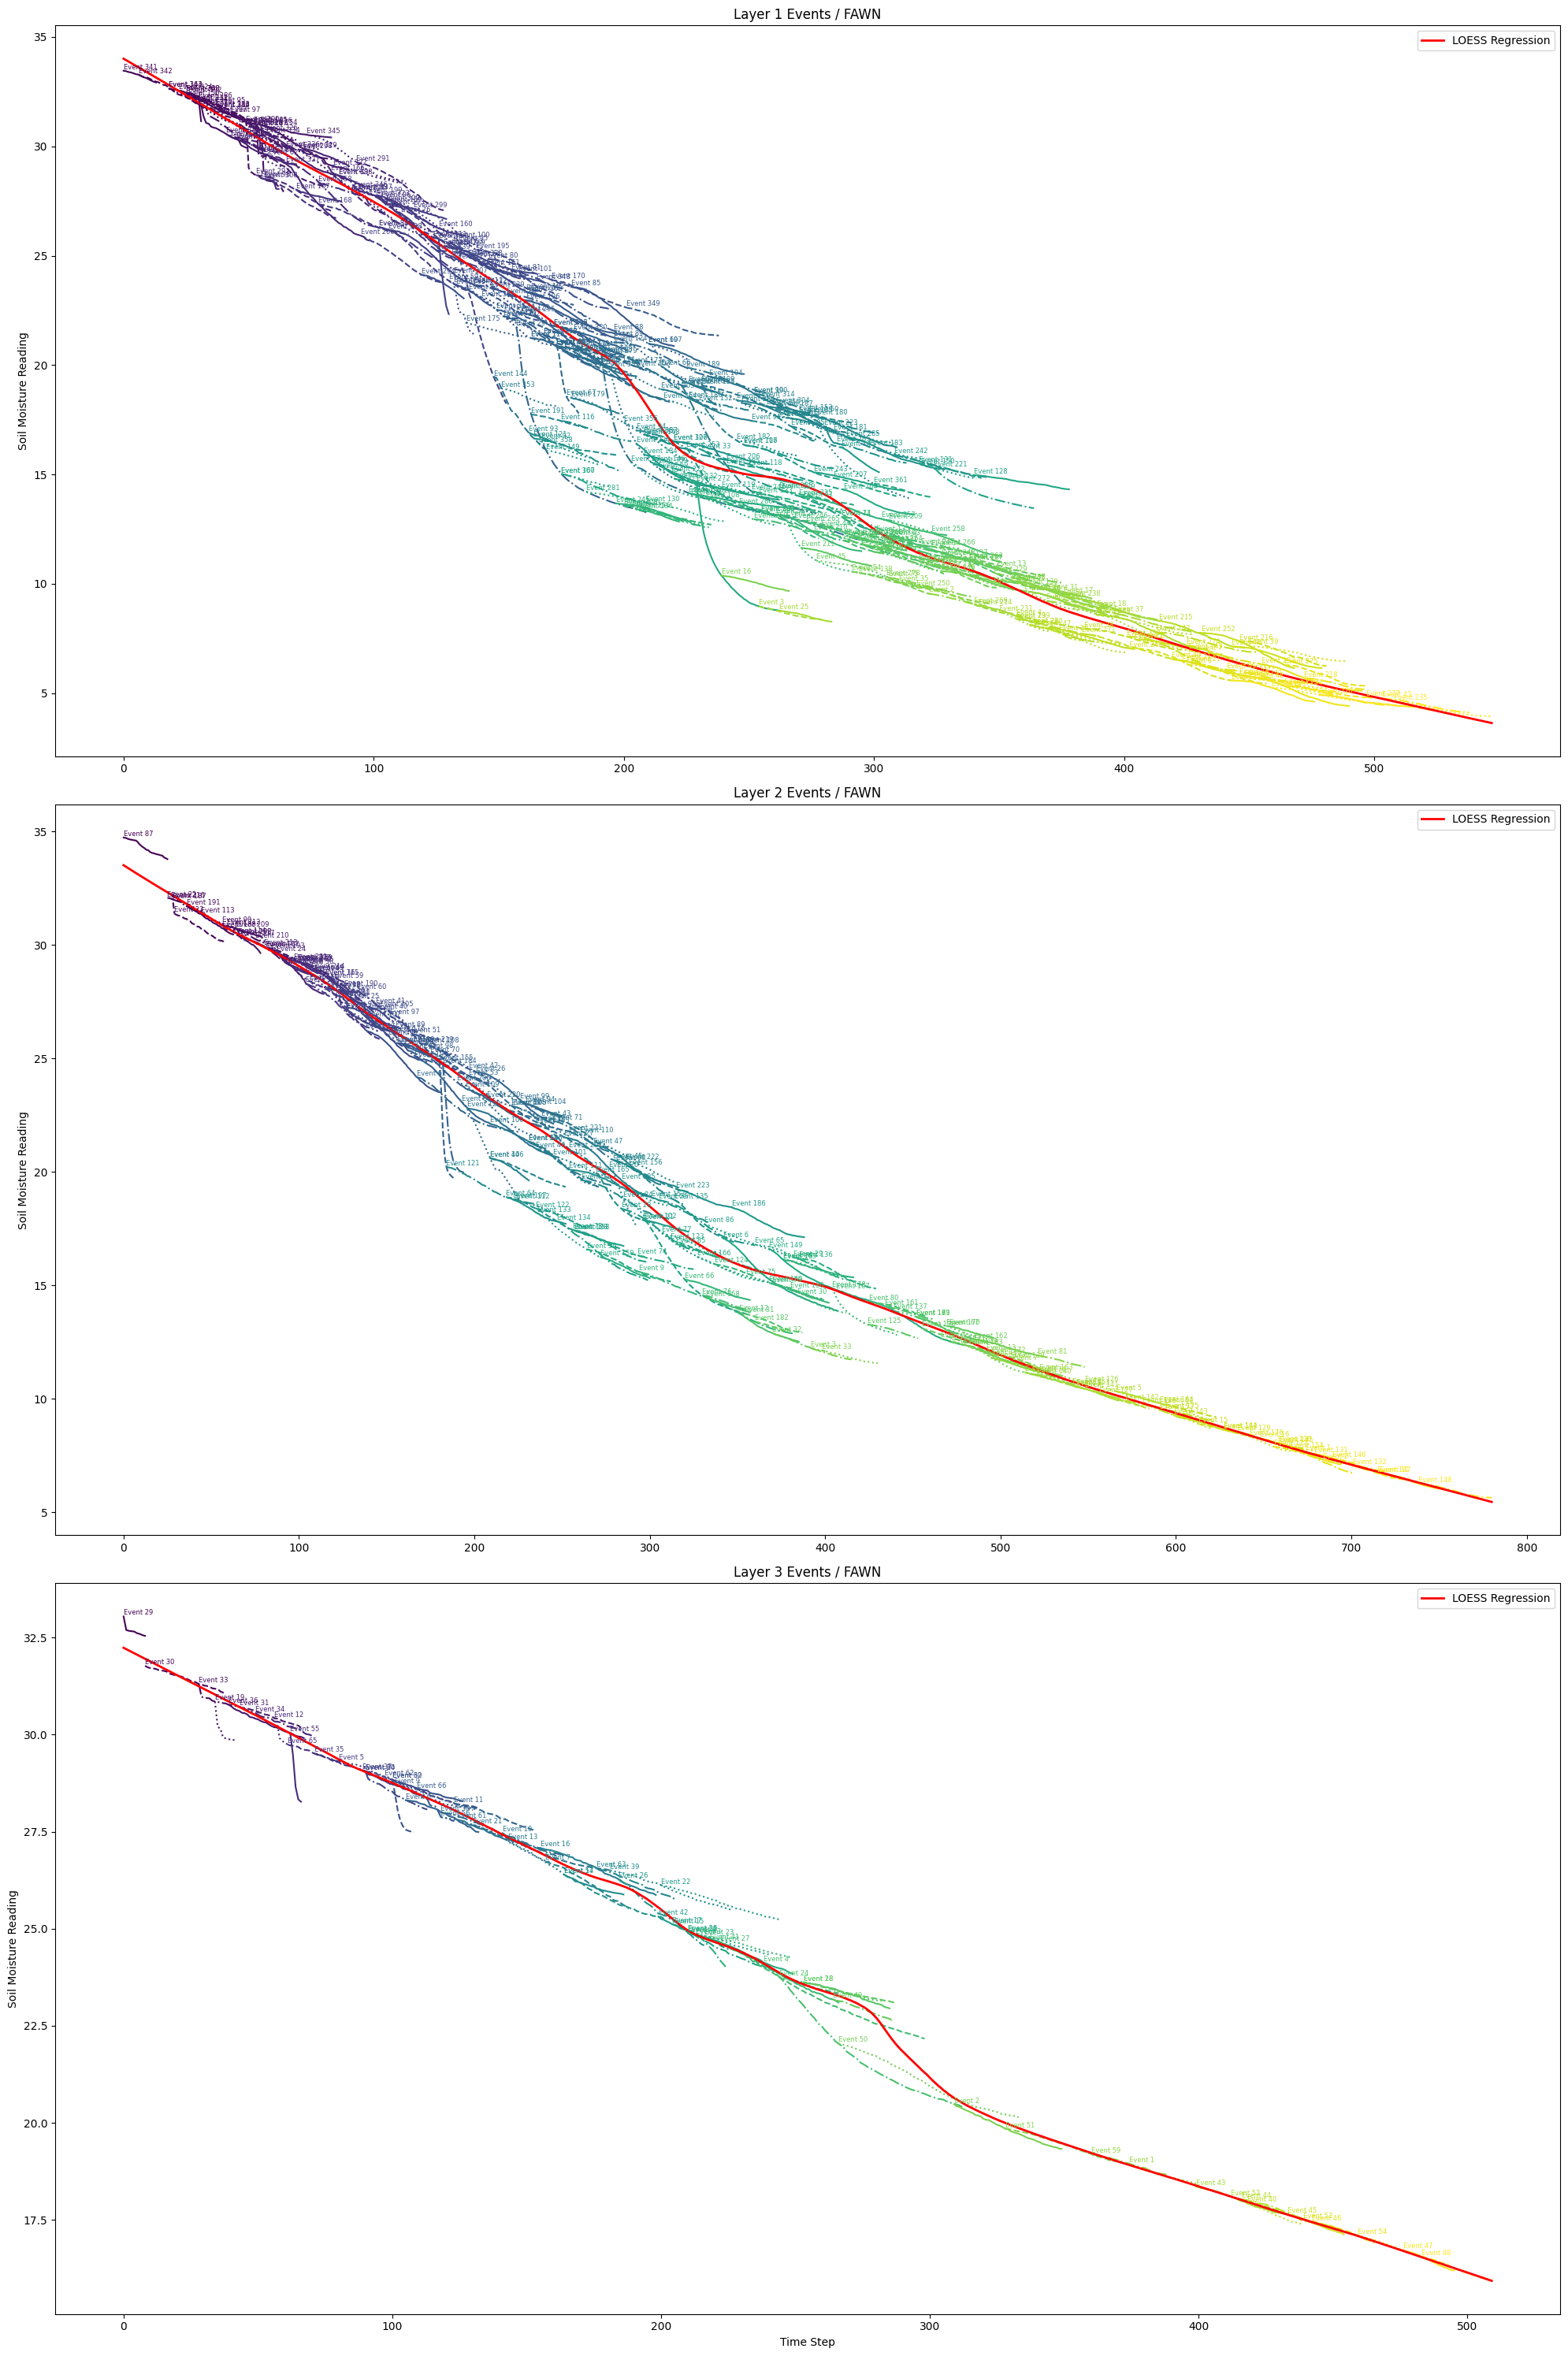

In [ ]:
Alachua_URL= "https://dl.dropboxusercontent.com/scl/fi/v4v12mcxq0ti5b8afg7bq/2324.csv?rlkey=ee3djvyo8amaxm39cx6yripb2&st=9lv477as&dl=0"
data = pd.read_csv(Alachua_URL, sep = ";")
data_alachua = data[data['ID'] == 260] #Alachua 
data_alachua.rename(columns={data.columns[1]: 'DateTime'}, inplace=True)
data_alachua = data_alachua.rename(columns={'moisture_sms_4_inch_pct': 'moisture_1', 'moisture_sms_8_inch_pct': 'moisture_2', 
                            'moisture_sms_12_inch_pct': 'moisture_3', 'moisture_sms_16_inch_pct': 'moisture_4', 'moisture_sms_20_inch_pct': 'moisture_5'})
last_5_columns = data_alachua.iloc[:, -5:]
second_column = data_alachua.iloc[:, [1]]
data_alachua = pd.concat([second_column, last_5_columns], axis=1)

data_alachua['DateTime'] = pd.to_datetime(data_alachua['DateTime'])

# Define the start and end of your desired time range
start_date = '2023-01-01'
end_date = '2024-12-01'


data_alachua_spring = data_alachua[(data_alachua['DateTime'] >= start_date) & (data_alachua['DateTime'] <= end_date)]

data_alachua_spring = data_alachua_spring.set_index('DateTime')
data_alachua_spring.index = pd.to_datetime(data_alachua_spring.index, errors='coerce')


def analyze_and_plot_data(data, depth_columns):
    # smoothed_data = data.copy()
    # for layer in depth_columns:
    #     smoothed_data[layer] = savgol_filter(data[layer], window_length, poly_order)

        # smoothed_data[layer] = data[layer]
    def detect_decreasing_events(series):
        decreasing_events = []
        count = 0
        start_index = None
        step = 3      

        mean_value = series.mean()
        std_dev = series.std()
        upper_limit = mean_value + 2 * std_dev

        for i in range(1, len(series)):
            if series[i] < series[i-1]:
                count += 1
                if count == 1:
                    start_index = i-1
            else:
                if count >= 4:
                    if series[start_index] - series[i] >= 0.5 and series[start_index] - series[i] <= 15:
                        event_slice = series[start_index:i]
                        if not (event_slice <= 1.5).any():
                            if (event_slice.max() - event_slice.min()) <= 15 and event_slice.min() > 2:
                                # Only include the event if its max value is within the acceptable range
                                if event_slice.max() <= upper_limit:
                                    decreasing_events.append((series.index[start_index], series.index[i-1]))
                count = 0
                start_index = None
        
        return decreasing_events

    decreasing_events_dict = {}
    for layer in depth_columns:
        decreasing_events_dict[layer] = detect_decreasing_events(data[layer])

    def plot_layer_events(layer, events, data):
        # Extract the data for the specific layer
        layer_data = data[layer]
        
        layer_data.plot(figsize=(15, 7), label=layer, linestyle='-', linewidth=1.5)

        for start, end in events:
            plt.axvspan(start, end, color='gray', alpha=0.8)

        plt.title(f'{layer} with Detected Events Highlighted / FAWN')
        plt.xlabel('DateTime')
        plt.ylabel('Moisture Value')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # for layer in depth_columns:
    #     plot_layer_events(layer, decreasing_events_dict[layer], data)

    return decreasing_events_dict

window_length = 49
poly_order = 3
depth_columns = [col for col in data_alachua_spring.columns if "moisture_" in col]



decreasing_events_alachua = analyze_and_plot_data(data_alachua_spring, depth_columns)


def resample_loess_curve(loess_x, loess_y, target_length):
    """
    Resample the LOESS curve to fit a specified x-range length.

    Parameters:
        loess_x (array-like): Original x-values of the LOESS curve.
        loess_y (array-like): Original y-values of the LOESS curve.
        target_length (int): Desired length of the x-range.

    Returns:
        tuple: Resampled x and y values.
    """
    # Generate the new x-range
    new_x = np.linspace(min(loess_x), max(loess_x), target_length)

    # Interpolate the LOESS curve
    interpolate_func = interp1d(loess_x, loess_y, kind='linear', fill_value="extrapolate")
    new_y = interpolate_func(new_x)

    return new_x, new_y
def Outlier_detection(event_data, threshold=5, window_size=10):

    if len(event_data) < window_size:
        return False

    for i in range(len(event_data) - window_size + 1):
        window = event_data[i:i + window_size]
        if np.max(window) - np.min(window) > threshold:
            return True
    return False

def Loess_moisture_events_FAWN_adjusted(data, events_dict):
    fig, axes = plt.subplots(len(depth_columns) - 2, 1, figsize=(20, 30))  # delete 4 and 5 

    loess_objects = {}  
    range_x = []
    target_length = 575  # Target length for the x-range
    resampled_loess_curves = []
    for idx, layer in enumerate(depth_columns[:-2]):  # delete 4 and 5 
        ax = axes[idx] if len(depth_columns) - 2 > 1 else axes  
        events = events_dict[layer]
        filtered_data = []

        for start, end in events:
            event_data = data[(data.index >= pd.to_datetime(start)) & (data.index <= pd.to_datetime(end))]
            if not Outlier_detection(event_data[layer].values):
                filtered_data.append(event_data)

        sorted_events_with_id = [(event_idx, event) for event_idx, event in sorted(enumerate(filtered_data), key=lambda pair: pair[1][layer].max(), reverse=True)]

        colors = plt.cm.viridis(np.linspace(0, 1, len(filtered_data)))
        all_x = []
        all_y = []
        first_event_peak = sorted_events_with_id[0][1][layer].max()
        
        line_styles = ['-', '--', '-.', ':']
        
        for sorted_idx, (event_idx, event) in enumerate(sorted_events_with_id):
            values = event[layer].dropna().tolist()
            if not values:
                continue

            if all_y:
                closest_val = min(values, key=lambda x: abs(x - first_event_peak))
                closest_idx_in_event = values.index(closest_val)
                values = values[closest_idx_in_event:]
                closest_idx_all_y = np.argmin([abs(val - closest_val) for val in all_y])
                start_x = all_x[closest_idx_all_y]
                x = np.arange(start_x, start_x + len(values))
            else:
                x = np.arange(0, len(values))

            linestyle = line_styles[sorted_idx % len(line_styles)]
            ax.plot(x, values, color=colors[sorted_idx], linestyle=linestyle)
            ax.annotate(f"Event {event_idx + 1}", (x[0], values[0]), fontsize=6, color=colors[sorted_idx], verticalalignment='bottom', horizontalalignment='left')
            all_x.extend(x)
            all_y.extend(values)
            
        range_x.append(all_x)  
        # Apply LOWESS
        lowess = sm.nonparametric.lowess
        endog = all_y  
        exog = all_x  
        loess_result = lowess(endog, exog, frac=0.1)  # frac is the fraction of data used for each local regression
        loess_objects[layer] = loess_result
        loess_x, loess_y = zip(*loess_result)

        # Resample the LOESS curve to match the target length
        resampled_loess_x, resampled_loess_y = resample_loess_curve(loess_x, loess_y, target_length)
        resampled_loess_curves.append((resampled_loess_x, resampled_loess_y))

        # Plot the resampled LOESS curve
        ax.plot(resampled_loess_x, resampled_loess_y, 'r-', linewidth=2, label='LOESS Regression')

        ax.set_title(f"Layer {idx + 1} Events / FAWN")
        ax.set_ylabel("Soil Moisture Reading")
        ax.legend(loc='upper right')

        # Print x-axis range for debugging
        print(f"Layer {idx + 1}: Resampled LOESS X-range: {min(resampled_loess_x)} to {max(resampled_loess_x)}")
    
    ax.set_xlabel("Time Step")
    plt.tight_layout()
    plt.show()

    return resampled_loess_curves

R_curve = Loess_moisture_events_FAWN_adjusted(data_alachua_spring, decreasing_events_alachua)

### Layer 1-3's Loess curve

In [7]:
moisture_1_x = R_curve[0][0]
moisture_1_x = np.arange(0, len(moisture_1_x))
moisture_1_y = R_curve[0][1]

moisture_2_x = R_curve[1][0]
moisture_2_x = np.arange(0, len(moisture_2_x))
moisture_2_y = R_curve[1][1]

moisture_3_x = R_curve[2][0]
moisture_3_x = np.arange(0, len(moisture_3_x))
moisture_3_y = R_curve[2][1]

# XGBoost model: Data prepare

In [ ]:
layer1 = df[df['Layer'] == 1].copy()
layer2 = df[df['Layer'] == 2].copy()
layer3 = df[df['Layer'] == 3].copy()


layer1 = layer1.rename(
    columns={
        'Peak Soil Moisture': 'L1_PeakSoilMoisture',
        'Increasing Event Duration (hours)': 'L1_IncreasingEventDuration',
        'Water Input': 'L1_WaterInput',
        'Initial SM': 'L1_InitialSM',
        'SM Increase': 'L1_SMIncrease'
    }
)

layer2 = layer2.rename(
    columns={
        'Peak Soil Moisture': 'L2_PeakSoilMoisture',
        'Increasing Event Duration (hours)': 'L2_IncreasingEventDuration',
        'Water Input': 'L2_WaterInput',
        'Initial SM': 'L2_InitialSM',
        'Increasing Time from L1 start (hours)': 'L2_IncreasingTimeFromL1Start',
        'SM Increase': 'L2_SMIncrease'
    }
)

layer3 = layer3.rename(
    columns={
        'Peak Soil Moisture': 'L3_PeakSoilMoisture',
        'Increasing Event Duration (hours)': 'L3_IncreasingEventDuration',
        'Water Input': 'L3_WaterInput',
        'Initial SM': 'L3_InitialSM',
        'Increasing Time from L1 start (hours)': 'L3_IncreasingTimeFromL1Start',
        'SM Increase': 'L3_SMIncrease'
    }
)


# Model 1 Data
X1_cols = [
    'L1_InitialSM',
    'L1_WaterInput',
    'L1_IncreasingEventDuration' 
]

Y1_cols = [
    'L1_IncreasingEventDuration', 
    'L1_SMIncrease'
]



X1 = layer1[X1_cols].values
Y1 = layer1[Y1_cols].values  


X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, 
    Y1,
    test_size=0.2, 
    random_state=42
)

# Model 2 Data

merged2 = pd.merge(
    layer1,
    layer2,
    on='Event',   
    how='inner'   
)

X2_cols = ['L2_InitialSM', 'L1_WaterInput', 'L1_IncreasingEventDuration']
Y2_cols = ['L2_IncreasingEventDuration', 'L2_SMIncrease']

X2 = merged2[X2_cols].values
Y2 = merged2[Y2_cols].values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, 
    Y2,
    test_size=0.2, 
    random_state=42
)

# Model 3

merged3 = pd.merge(
    layer1,
    layer3,
    on='Event',   
    how='inner'  
)


X3_cols = ['L3_InitialSM', 'L1_WaterInput', 'L1_IncreasingEventDuration']
Y3_cols = ['L3_IncreasingEventDuration', 'L3_SMIncrease']

X3 = merged3[X3_cols].values
Y3 = merged3[Y3_cols].values

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, 
    Y3,
    test_size=0.2, 
    random_state=42
)

### XGBoost Model for Layer 1-3

In [9]:
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,  
    tree_method="hist"  
)

model_1 = MultiOutputRegressor(xgb_reg)
model_1.fit(X1_train, y1_train)

xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,  
    tree_method="hist"  
)

model_2 = MultiOutputRegressor(xgb_reg)
model_2.fit(X2_train, y2_train)


xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,  
    tree_method="hist"  
)

model_3 = MultiOutputRegressor(xgb_reg)
model_3.fit(X3_train, y3_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

### Performance test

In [18]:
# train_score = model_1.score(X_train, y_train)
# test_score = model_1.score(X_test, y_test)

# print("Training R^2 Score:", train_score)
# print("Testing R^2 Score:", test_score)

# # Make predictions
# y_pred = model_1.predict(X_test)

# # Display predictions vs actuals
# for i, target in enumerate(Y_cols):
#     print(f"Target: {target}")
#     print("Actual:", y_test[:5, i])
#     print("Predicted:", y_pred[:5, i])
#     print("-" * 30)

In [19]:
# output_names = [
#     "L1 Increasing Event Duration",
#     "L1 SM Increase"
# ]

# # Loop over each output column and create a scatter plot of Actual vs. Predicted
# for idx, name in enumerate(output_names):
#     y_test_col = y_test[:, idx]
#     y_pred_col = y_pred[:, idx]
    
#     plt.figure(figsize=(8, 6))
#     plt.scatter(y_test_col, y_pred_col, alpha=0.5, label="Predictions")
#     plt.plot(
#         [y_test_col.min(), y_test_col.max()],
#         [y_test_col.min(), y_test_col.max()],
#         'r--',
#         label="Ideal Fit (y=x)"
#     )
#     plt.xlabel(f"Actual {name}")
#     plt.ylabel(f"Predicted {name}")
#     plt.title(f"Actual vs. Predicted {name}")
#     plt.legend()
#     plt.grid(True)
#     plt.show()



# Stack model : Surface Layer 1

### Segment detection (Detect if exist precipitation event cause soil moisture increase & decrease)

In [ ]:
Stack_df = pd.read_csv(Alachua_URL, sep = ";")


stack_alachua = Stack_df[Stack_df['ID'] == 260] #Alachua 
stack_alachua.rename(columns={Stack_df.columns[1]: 'DateTime'}, inplace=True)
stack_alachua = stack_alachua.rename(columns={'moisture_sms_4_inch_pct': 'moisture_1', 'moisture_sms_8_inch_pct': 'moisture_2', 
                            'moisture_sms_12_inch_pct': 'moisture_3', 'moisture_sms_16_inch_pct': 'moisture_4', 'moisture_sms_20_inch_pct': 'moisture_5'})
last_5_columns = stack_alachua.iloc[:, -5:]
second_column = stack_alachua.iloc[:, [1]]
stack_alachua = pd.concat([second_column, last_5_columns], axis=1)

def smooth_data(df, value_col, window=3):
    df = df.copy()
    df['smooth'] = df[value_col].rolling(window=window, center=True, min_periods=1).mean()
    return df

def detect_local_extrema(df, value_col="moisture_1"):

    df = df.copy().reset_index(drop=True)
    y = df[value_col].values

    slope_sign = np.sign(np.diff(y))
    minima_indices = []
    maxima_indices = []

    for i in range(1, len(slope_sign)):
        prev_sign = slope_sign[i-1]
        curr_sign = slope_sign[i]


        if prev_sign > 0 and curr_sign < 0:
            maxima_indices.append(i)

        if prev_sign < 0 and curr_sign > 0:
            minima_indices.append(i)
    
    return minima_indices, maxima_indices

def split_into_segments(
    df, 
    datetime_col="DateTime", 
    value_col="moisture_1", 
    min_amplitude=2.0,   
    min_duration=1.0,    
    smooth_window=3       
):


    df = df.sort_values(datetime_col).reset_index(drop=True).copy()
    
    # 1) Smooth data to reduce small wiggles
    df_smooth = smooth_data(df, value_col, window=smooth_window)
    
    # 2) Detect local min/max on the smoothed column

    minima_inds, maxima_inds = detect_local_extrema(df_smooth, value_col='smooth')

    # Minma, max
    if len(minima_inds) == 0 or minima_inds[0] != 0:
        minima_inds.insert(0, 0)
    if minima_inds[-1] != (len(df_smooth) - 1):
        minima_inds.append(len(df_smooth) - 1)

    segments = []
    
    # 3) Build segments
    for i in range(len(minima_inds) - 1):
        minA_idx = minima_inds[i]
        minB_idx = minima_inds[i+1]
        

        local_maxes = [m for m in maxima_inds if m >= minA_idx and m <= minB_idx]
        
        if local_maxes:
            max_idx = local_maxes[np.argmax(df_smooth.loc[local_maxes, 'smooth'].values)]
        else:
            max_idx = None
        
        seg_df = df.loc[minA_idx : minB_idx].copy()
        seg_df.reset_index(drop=True, inplace=True)
        
        amplitude = 0
        if max_idx is not None:
            amplitude = df_smooth.loc[max_idx, 'smooth'] - df_smooth.loc[minA_idx, 'smooth']

        duration_hours = 0
        if len(seg_df) > 1:
            start_time = seg_df.iloc[0][datetime_col]
            end_time   = seg_df.iloc[-1][datetime_col]
            delta = end_time - start_time
            duration_hours = delta.total_seconds() / 3600.0
        else:
            duration_hours = 0
        
        if amplitude >= min_amplitude and duration_hours >= min_duration:
            segments.append(seg_df)

    return segments


def plot_segments(segments, datetime_col="DateTime", value_col="moisture_1"):

    plt.figure(figsize=(14, 6))
    colors = [
        "blue", "red", "green", "orange", "magenta", "cyan", "lime", "purple",
        "darkgreen", "brown", "darkblue", "yellow"
    ]
    
    for i, seg_df in enumerate(segments):
        color = colors[i % len(colors)]
        plt.plot(seg_df[datetime_col], seg_df[value_col], 
                 color=color, 
                 label=f"Segment {i+1}")
    
    plt.xlabel("DateTime")
    plt.ylabel(value_col)
    plt.title("Filtered Segments (Local Min->Max->Min)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.show()


In [13]:
def Segment_split(dataset, depth_column, start, end):
    # fig, ax = plt.subplots(figsize=(15, 6))

    # 1) Filter data
    dataset = dataset.copy()
    dataset['DateTime'] = pd.to_datetime(dataset['DateTime'])
    mask = (dataset['DateTime'] >= start) & (dataset['DateTime'] <= end)
    df_range = dataset[mask].sort_values(by='DateTime').reset_index(drop=True)

    # 2) Outlier removal (threshold = -5)
    df_range['diff'] = df_range[depth_column].diff()
    threshold = -5
    sudden_drop_mask = df_range['diff'] < threshold
    df_dropped = df_range[~sudden_drop_mask].copy()  # keep them out

    # 3) Detect segments in df_dropped
    segments = split_into_segments(
        df_dropped, 
        datetime_col="DateTime",
        value_col=depth_column,
        min_amplitude=2.0,  
        min_duration=2.0,   
        smooth_window=5
    )

    if len(segments) == 0:
        # ax.plot(df_dropped['DateTime'], df_dropped[depth_column], color='blue', label='All Data')
        # ax.set_xlabel('DateTime')
        # ax.set_ylabel(depth_column)
        # ax.set_title('No Segments Detected')
        # ax.legend()
        # ax.grid(True)
        # plt.show()
        return df_dropped

    # 4) Extract the start time for each segment

    segment_starts = [seg.iloc[0]['DateTime'] for seg in segments]
    segment_starts = sorted(segment_starts)

    last_time = df_dropped['DateTime'].max()
    if segment_starts[-1] < last_time:
        segment_starts.append(last_time + pd.Timedelta(seconds=1))

    colors = [
        "blue", "red", "green", "orange", "magenta", "cyan", 
        "lime", "purple", "darkgreen", "brown", "darkblue", "yellow"
    ]
    n_segments = len(segment_starts) - 1
    segment_dict = {}
    for i in range(n_segments):
        seg_start = segment_starts[i]
        seg_end   = segment_starts[i+1]
        seg_mask  = (df_dropped['DateTime'] >= seg_start) & (df_dropped['DateTime'] < seg_end)
        seg_df    = df_dropped[seg_mask]
        segment_number = i +1
        segment_dict[segment_number] = seg_df

        color = colors[i % len(colors)]
        # ax.plot(seg_df['DateTime'], seg_df[depth_column], color=color, label=f"Segment {i+1}")

    # ax.set_xlabel('DateTime')
    # ax.set_ylabel(depth_column)
    # ax.set_title('Data with Outliers Removed, Colored by Segment')
    # ax.legend()
    # ax.grid(True)
    # plt.show()

    return segment_dict



### Surface layer 1's event detection

In [ ]:
start = "2023-05-18"
end   = "2023-05-30"
Segment_1 = Segment_split(stack_alachua, "moisture_1", start, end)

### Weather API: Open-Meteo

In [ ]:
def get_hourly_precipitation(lat, lon, start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,  
        "end_date": end_date,      
        "hourly": "precipitation",
        "timezone": "UTC"
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()

    if "hourly" in data and "time" in data["hourly"] and "precipitation" in data["hourly"]:
        times = data["hourly"]["time"]
        values = data["hourly"]["precipitation"]
        df = pd.DataFrame({
            "date": pd.to_datetime(times),
            "precipitation_mm": values
        })

        return df
    else:
        raise ValueError("No precipitation data found in response.")


# Surface layer 1's Soil Moisture modelling & Forcasting 

#####  Input parameter: Segment_1 (soil moisture segemented in preipitation event, if sm data exist), 
#####                        filtered_rows (SMAP data),
#####                        model_1 (XGBoost model),
#####                        moisture_1_x, (SMDE layer 1 curve in x axis )
#####                        moisture_1_y, (SMDE layer 1 curve in y axis )
#####                       start_dt (start time)
#####                        end_dt (end time)

In [ ]:
def Model_1_Function(Segment_1, filtered_rows, model_1, 
                     moisture_1_x, moisture_1_y, start_dt, end_dt, longitude, latitude):


    # Weather API called
    precip_input = get_hourly_precipitation(longitude, latitude, 
                                            start_dt.strftime("%Y-%m-%d"), 
                                            end_dt.strftime("%Y-%m-%d"))


    # According SMAP point to draw soil moisture changing pattern via XGBoost and SMDE model
    def build_rise_decay_curve_with_SMAP(segment_layer, precip, SMAP_DATA, model, m1_x, m1_y, 
                                         ratio, window_days=2, dt_minutes=15, prev_decreasing_end_value=None):

        peak_idx = segment_layer['moisture_1'].idxmax()
        df_before_peak = segment_layer.loc[:peak_idx].copy()
        df_before_peak['DateTime'] = pd.to_datetime(df_before_peak['DateTime'])
        precip = precip.copy()
        precip['date'] = pd.to_datetime(precip['date'])
        df_before_peak['Water_Input'] = 0.0
        # Sum precipitation within ±window_days for each timestamp
        for i, row in df_before_peak.iterrows():
            center_time = row['DateTime']
            lower_bound = center_time - pd.Timedelta(days=window_days)
            upper_bound = center_time + pd.Timedelta(days=window_days)
            mask = (precip['date'] >= lower_bound) & (precip['date'] <= upper_bound)
            if not precip[mask].empty:
                df_before_peak.loc[i, 'Water_Input'] = precip[mask]['precipitation_mm'].sum()
        #  Extract features before the peak
        df_before_peak = df_before_peak.sort_values('DateTime').reset_index(drop=True)
        peak_time = df_before_peak.loc[df_before_peak['moisture_1'].idxmax(), 'DateTime']
        init_sm = df_before_peak.loc[0, 'moisture_1']
        duration_hrs = (peak_time - df_before_peak.loc[0, 'DateTime']).total_seconds() / 3600.0
        water_in = df_before_peak.loc[0, 'Water_Input']
        features = {'L1_InitialSM': prev_decreasing_end_value if prev_decreasing_end_value is not None else init_sm,
                    'L1_IncreasingEventDuration': duration_hrs,
                    'L1_WaterInput': water_in}
        #  Predict increasing curve parameters using the XGBoost model.
        X_input = np.array([[features['L1_InitialSM'], features['L1_IncreasingEventDuration'], features['L1_WaterInput']]])
        preds = model.predict(X_input)
        T_hrs, sm_increase_pr = preds[0][0], preds[0][1]
        T_minutes = T_hrs * 60
        peak_SM = features['L1_InitialSM'] + sm_increase_pr
        if T_minutes == 0:
            a, c = 0, features['L1_InitialSM']
        else:
            a = (peak_SM - features['L1_InitialSM']) / (T_minutes**2)
            c = features['L1_InitialSM']
        t_values = np.arange(0, T_minutes + dt_minutes, dt_minutes)
        sm_values = a * (t_values**2) + c
        datetime_t_values = [segment_layer.iloc[0]['DateTime'] + pd.Timedelta(minutes=int(x)) for x in t_values]
        # Slice decreasing curve from SMDE model 
        after_dur_mins = (segment_layer.iloc[-1]['DateTime'] - segment_layer.iloc[0]['DateTime']).total_seconds() / 60.0
        target_val = sm_values[-1]
        diffs = np.abs(m1_y - target_val)
        idx_found = np.argmin(diffs)
        intervals = int(after_dur_mins / dt_minutes)
        arr_from_peak = m1_x[idx_found: idx_found + intervals + 1]
        datetime_red_time = [segment_layer.iloc[0]['DateTime'] + pd.Timedelta(minutes=int((val - m1_x[0]) * dt_minutes)) for val in arr_from_peak]
        red_vals = m1_y[arr_from_peak]
        # SMAP point added
        SMAP_DATA = SMAP_DATA.copy()
        SMAP_DATA['Datetime'] = pd.to_datetime(SMAP_DATA['Date']) + pd.Timedelta(hours=6)
        smap_points = []
        for smap_dt, smap_val in zip(SMAP_DATA['Datetime'], SMAP_DATA['SPL3SMP_E_006_Soil_Moisture_Retrieval_Data_AM_soil_moisture']):
            if start_dt <= smap_dt <= end_dt:
                smap_points.append((smap_dt, smap_val))
        return datetime_t_values, sm_values, datetime_red_time, red_vals, smap_points

    #  Mutiple increasing and decreasing curve merged in one dataframe ready to output and plot
    def merge_multiple_curves(Segment_1, precip, SMAP_data, model, m1_x, m1_y, window_days=2, dt_minutes=15):
        all_datetime, all_y, all_smap_points = [], [], []
        prev_decreasing_end_value = None
        for key in sorted(Segment_1.keys()):
            segment = Segment_1[key]
            blue_time, blue_vals, red_time, red_vals, smap_points = build_rise_decay_curve_with_SMAP(
                segment, precip, SMAP_data, model, m1_x, m1_y, ratio=key,
                window_days=window_days, dt_minutes=dt_minutes,
                prev_decreasing_end_value=prev_decreasing_end_value
            )
            all_datetime += list(blue_time) + list(red_time)
            all_y += list(blue_vals) + list(red_vals)
            all_smap_points += smap_points
            if len(red_vals) > 0:
                prev_decreasing_end_value = red_vals[-1]
        combined = sorted(zip(all_datetime, all_y), key=lambda x: x[0])
        unique_datetime, unique_y = [], []
        for dt_val, y_val in combined:
            if unique_datetime and dt_val == unique_datetime[-1]:
                continue
            unique_datetime.append(dt_val)
            unique_y.append(y_val)
        return {"main_datetime": unique_datetime, "main_values": unique_y, "smap_points": all_smap_points}

    # Check Precipitation if happens during two SMAP point 
    def check_precipitation_between_smap(smap_time, next_smap_time, precipitation_df):
        precipitation_df = precipitation_df.copy()
        precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
        mask = (precipitation_df['date'] >= smap_time) & (precipitation_df['date'] < next_smap_time)
        events = precipitation_df[mask]
        event_details = []
        for _, row in events.iterrows():
            if row['precipitation_mm'] > 1:
                event_details.append({'event_time': row['date'], 'water_input': row['precipitation_mm']})
        return event_details

    # Call this function to draw increasing curve generate by XGBoost model
    def generate_increasing_curve(event_detail, model, dt_minutes=15):
        X_input = np.array([[event_detail['current_sm'], 0, event_detail['water_input']]])
        preds = model.predict(X_input)
        T_hrs, sm_increase = preds[0][0], preds[0][1]
        T_minutes = T_hrs * 60
        initial_SM = event_detail['current_sm']
        peak_SM = initial_SM + sm_increase
        if T_minutes == 0:
            a, c = 0, initial_SM
        else:
            a = (peak_SM - initial_SM) / (T_minutes**2)
            c = initial_SM
        t_values = np.arange(0, T_minutes + dt_minutes, dt_minutes)
        sm_values = a * (t_values**2) + c
        inc_times = [event_detail['event_time'] + pd.Timedelta(minutes=int(x)) for x in t_values]
        return inc_times, sm_values

#------------------------------------------------------------------------------------
################### Work flow ###################

    # 1. Merge segments to get a combined model-generated curve (if user has previsou SM data) and SMAP calibration points.
    merged = merge_multiple_curves(Segment_1, precip_input, filtered_rows, model_1, moisture_1_x, moisture_1_y)
    combined_time = merged["main_datetime"]
    combined_vals = merged["main_values"]
    all_smap_points = merged["smap_points"]

    if isinstance(combined_time[0], (int, float, np.integer, np.floating)):
        sorted_smap_points = sorted(all_smap_points, key=lambda x: x[0])
        origin = pd.to_datetime(sorted_smap_points[0][0])
        combined_time = [origin + pd.Timedelta(minutes=t) for t in combined_time]
    else:
        combined_time = pd.to_datetime(combined_time)

    sorted_smap_points = sorted(all_smap_points, key=lambda x: x[0])
    sorted_smap_points = [(pd.to_datetime(t), v) for t, v in sorted_smap_points]

    # 2. SMAP calibrated curve (XGBoost and SMDE model used)
    dt_minutes = 15
    modified_mini_curves = []
    for i, (smap_time, smap_val) in enumerate(sorted_smap_points):
        next_smap_time = sorted_smap_points[i+1][0] if i < len(sorted_smap_points)-1 else smap_time + pd.Timedelta(hours=24)
        precip_events = check_precipitation_between_smap(smap_time, next_smap_time, precip_input)
        segments_list = []
        current_time = smap_time
        current_sm = smap_val
        for event in sorted(precip_events, key=lambda ev: ev['event_time']):
            precip_time = event['event_time']
            water_input = event['water_input']
            after_dur_mins = (precip_time - current_time).total_seconds() / 60.0
            intervals = int(after_dur_mins // dt_minutes)
            if intervals <= 0:
                inc_times, inc_vals = generate_increasing_curve({'event_time': precip_time,
                                                                  'water_input': water_input,
                                                                  'current_sm': current_sm}, 
                                                                 model_1, dt_minutes)
                segments_list.append((inc_times, inc_vals))
                if inc_times:
                    current_time, current_sm = inc_times[-1], inc_vals[-1]
                continue
            diffs = np.abs(np.array(moisture_1_y) - current_sm)
            idx_found = np.argmin(diffs)
            start_idx = idx_found
            end_idx = start_idx + intervals
            if end_idx > len(moisture_1_y)-1:
                end_idx = len(moisture_1_y)-1
            if start_idx > end_idx:
                inc_times, inc_vals = generate_increasing_curve({'event_time': precip_time,
                                                                  'water_input': water_input,
                                                                  'current_sm': current_sm}, 
                                                                 model_1, dt_minutes)
                segments_list.append((inc_times, inc_vals))
                if inc_times:
                    current_time, current_sm = inc_times[-1], inc_vals[-1]
                continue
            dec_sub_y = moisture_1_y[start_idx:end_idx+1]
            dec_sub_times = [current_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(dec_sub_y))]
            segments_list.append((dec_sub_times, dec_sub_y))
            current_time, current_sm = dec_sub_times[-1], dec_sub_y[-1]
            inc_times, inc_vals = generate_increasing_curve({'event_time': precip_time,
                                                              'water_input': water_input,
                                                              'current_sm': current_sm}, 
                                                             model_1, dt_minutes)
            segments_list.append((inc_times, inc_vals))
            if inc_times:
                current_time, current_sm = inc_times[-1], inc_vals[-1]
        # Final segment if current_time is before next SMAP point:
        if current_time < next_smap_time:
            leftover_minutes = (next_smap_time - current_time).total_seconds() / 60.0
            intervals = int(leftover_minutes // dt_minutes)
            diffs = np.abs(np.array(moisture_1_y) - current_sm)
            idx_found = np.argmin(diffs)
            start_idx = idx_found
            end_idx = start_idx + intervals
            if end_idx > len(moisture_1_y)-1:
                end_idx = len(moisture_1_y)-1
            if start_idx <= end_idx:
                dec_sub_y = moisture_1_y[start_idx:end_idx+1]
                dec_sub_times = [current_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(dec_sub_y))]
                segments_list.append((dec_sub_times, dec_sub_y))
        else:
            diff_minutes = (sorted_smap_points[i+1][0] - smap_time).total_seconds() / 60.0 if i < len(sorted_smap_points)-1 else 24*60
            num_steps = int(round(diff_minutes / dt_minutes))
            diffs = np.abs(np.array(moisture_1_y) - smap_val)
            idx_found = np.argmin(diffs)
            start_idx = idx_found
            end_idx = start_idx + num_steps
            sub_y = moisture_1_y[start_idx:end_idx]
            sub_times = [smap_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(sub_y))]
            segments_list.append((sub_times, sub_y))
        final_times, final_vals = [], []
        for ts, vals in segments_list:
            final_times.extend(ts)
            final_vals.extend(vals)
        modified_mini_curves.append((final_times, final_vals, smap_time))

    # 3. Build a 5-day forecast curve starting from user gived end time as current time
    final_times_mini, final_vals_mini, _ = modified_mini_curves[-1]
    new_start = final_times_mini[-1]
    new_start_sm = final_vals_mini[-1]
    new_end = new_start + pd.Timedelta(days=5)
    new_start_str, new_end_str = new_start.strftime('%Y-%m-%d'), new_end.strftime('%Y-%m-%d')

    precip_df_daily = get_hourly_precipitation(longitude, latitude, new_start_str, new_end_str)
    precip_threshold = 1
    precip_events_new = []
    for _, row in precip_df_daily.iterrows():
        if row['precipitation_mm'] > precip_threshold:
            event_time = row['date']
            if new_start <= event_time < new_end:
                precip_events_new.append({'event_time': event_time, 'water_input': row['precipitation_mm']})
    precip_events_new = sorted(precip_events_new, key=lambda ev: ev['event_time'])
    forecast_segments = []
    current_time, current_sm = new_start, new_start_sm
    for event in precip_events_new:
        event_time = event['event_time']
        after_dur_mins = (event_time - current_time).total_seconds() / 60.0
        intervals = int(after_dur_mins / dt_minutes)
        diffs = np.abs(np.array(moisture_1_y) - current_sm)
        idx_found = np.argmin(diffs)
        start_idx = idx_found
        end_idx = start_idx + intervals
        if end_idx > len(moisture_1_y)-1:
            end_idx = len(moisture_1_y)-1
        dec_sub_y = moisture_1_y[start_idx:end_idx+1]
        dec_sub_times = [current_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(dec_sub_y))]
        forecast_segments.append((dec_sub_times, dec_sub_y))
        if dec_sub_times:
            current_time, current_sm = dec_sub_times[-1], dec_sub_y[-1]
        inc_times, inc_vals = generate_increasing_curve({'event_time': event_time,
                                                         'water_input': event['water_input'],
                                                         'current_sm': current_sm},
                                                        model_1, dt_minutes)
        forecast_segments.append((inc_times, inc_vals))
        if inc_times:
            current_time, current_sm = inc_times[-1], inc_vals[-1]
    if current_time < new_end:
        after_dur_mins = (new_end - current_time).total_seconds() / 60.0
        intervals = int(after_dur_mins / dt_minutes)
        diffs = np.abs(np.array(moisture_1_y) - current_sm)
        idx_found = np.argmin(diffs)
        start_idx = idx_found
        end_idx = start_idx + intervals
        dec_sub_y = moisture_1_y[start_idx:end_idx+1]
        dec_sub_times = [current_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(dec_sub_y))]
        forecast_segments.append((dec_sub_times, dec_sub_y))
    forecast_times, forecast_vals = [], []
    for ts, vals in forecast_segments:
        forecast_times.extend(ts)
        forecast_vals.extend(vals)


    # 4. Final Plot: "Modelling with SMAP Calibration & Forecasting"
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    if sorted_smap_points:
        smap_times, smap_vals = zip(*sorted_smap_points)
        plt.scatter(smap_times, smap_vals, color='purple', label='SMAP Point')
    soil_color = 'green'
    for sub_times, sub_vals, _ in modified_mini_curves:
        plt.plot(sub_times, sub_vals, linestyle='--', color=soil_color)
    plt.plot(forecast_times, forecast_vals, linestyle='-', color=soil_color, linewidth=2, label='Prediction Soil Moisture')
    if forecast_times:
        plt.plot([new_start, forecast_times[0]], [new_start_sm, forecast_vals[0]], linestyle='--', color=soil_color)
    plt.axvline(x=new_start, color='black', linewidth=3, linestyle='-', label='Current Time')
    plt.gcf().text(0.25, 0.97, "Modelling", ha='center', va='center', fontsize=14, fontweight='bold')
    plt.gcf().text(0.75, 0.97, "Forecasting", ha='center', va='center', fontsize=14, fontweight='bold')
    
    # Precipitation as rectangles.

    ymin, ymax = ax.get_ylim()
    precip_base = 0
    rect_width = pd.Timedelta(hours=1)
    for _, row in precip_input.iterrows():
        date_val = pd.to_datetime(row['date'])
        precip_amt = row['precipitation_mm']
        if date_val < end_dt:
            rect = patches.Rectangle((date_val - pd.Timedelta(minutes=30), precip_base),
                                    rect_width, precip_amt, facecolor='blue', alpha=0.3, edgecolor='none')
            ax.add_patch(rect)


    for _, row in precip_df_daily.iterrows():
        date_val = pd.to_datetime(row['date'])
        precip_amt = row['precipitation_mm']
        if new_start <= date_val < new_end:
            rect = patches.Rectangle((date_val - pd.Timedelta(minutes=30), precip_base),
                                    rect_width, precip_amt, facecolor='red', alpha=0.3, edgecolor='none')
            ax.add_patch(rect)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate(rotation=0, ha='center')
    # Use new_end (forecast horizon) as the x-axis end.
    plt.xlim([start_dt, new_end])
    plt.ylim(0, 30)
    plt.title("Modelling with SMAP Calibration & Forecasting")
    plt.xlabel("Time")
    plt.ylabel("Soil Moisture (%)")
    plt.grid(True)
    plt.legend()
    plt.show()

  
    # 5. Output DataFrame 
    all_times = set()
    for t, _ in sorted_smap_points:
        all_times.add(t)
    for sub_times, _, _ in modified_mini_curves:
        all_times.update(sub_times)
    all_times.update(forecast_times)
    all_times.add(new_start)
    precip_input['date'] = pd.to_datetime(precip_input['date'])
    for d in precip_input['date']:
        all_times.add(d)
    all_times = [t for t in all_times if t <= new_end]
    all_times = sorted(all_times)
    df = pd.DataFrame(index=all_times)
    df['SMAP Point (m3/m3)'] = np.nan
    for t, v in sorted_smap_points:
        df.loc[t, 'SMAP Point (m3/m3)'] = v
    df['Soil moisture curve (m3/m3) Surface'] = np.nan
    for sub_times, sub_vals, _ in modified_mini_curves:
        for t, v in zip(sub_times, sub_vals):
            df.loc[t, 'Soil moisture curve (m3/m3) Surface'] = v
    for t, v in zip(forecast_times, forecast_vals):
        df.loc[t, 'Soil moisture curve (m3/m3) Surface'] = v
    df.loc[new_start, 'Soil moisture curve (m3/m3) Surface'] = new_start_sm
    df['water amount(mm)'] = np.nan
    df['water type'] = np.nan
    for _, row in precip_input.iterrows():
        date_val = pd.to_datetime(row['date'])
        amt = row['precipitation_mm']
        if amt >= 0.1:
            df.loc[date_val, 'water amount(mm)'] = amt
            if date_val.date() == dt.date(2023, 5, 23):
                df.loc[date_val, 'water type'] = 'Irrigation'
            else:
                df.loc[date_val, 'water type'] = 'Precipitation'
    df['Current Time'] = new_start
    df.sort_index(inplace=True)
    
    df_out = pd.DataFrame({
        "time": pd.date_range(start=start_dt, periods=100, freq="15T"),
        "Soil moisture curve (m3/m3) Surface": np.linspace(0.1, 0.3, 100),
        "SMAP Point (m3/m3)": np.nan  # For illustration
    })
    new_start = df_out["time"].iloc[-1]


    return df_out, new_start



### Example 

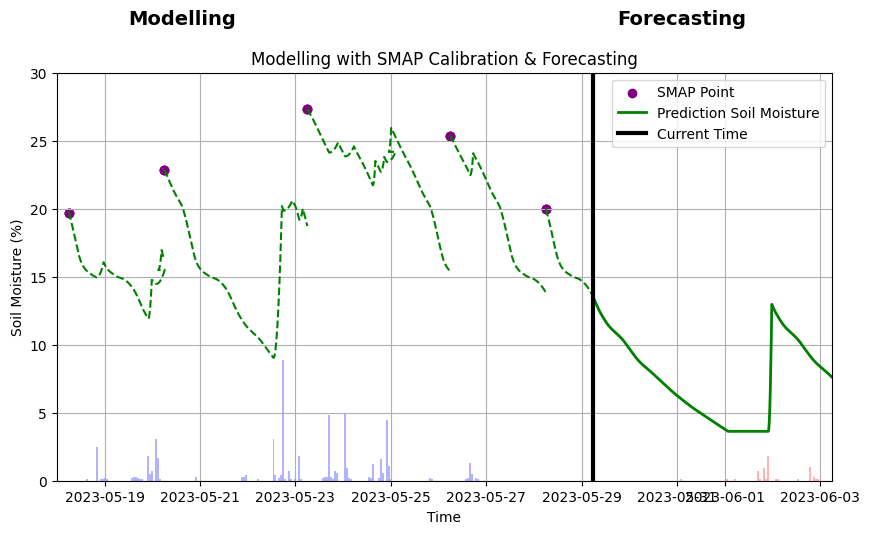

C:\Users\Win11_Chi\AppData\Local\Temp\ipykernel_4440\3791673505.py:402: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Precipitation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[date_val, 'water type'] = 'Precipitation'
C:\Users\Win11_Chi\AppData\Local\Temp\ipykernel_4440\3791673505.py:407: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  "time": pd.date_range(start=start_dt, periods=100, freq="15T"),


In [74]:
start_dt = dt.datetime(2023, 5, 18, 0, 0)
end_dt   = dt.datetime(2023, 5, 31, 0, 0)
model_1_df, current = Model_1_Function(Segment_1, filtered_rows, 
                                         model_1, moisture_1_x, moisture_1_y, 
                                         start_dt, end_dt, longitude= 29.6516, latitude= -82.3248)

# Layer 2 RootZone Soil Moisture 

In [ ]:
def merge_precip_events(precip_df, merge_hours=3):



    df_nonzero = precip_df[precip_df['precipitation_mm'] > 0].copy()
    if df_nonzero.empty:
        return []


    df_nonzero['date'] = pd.to_datetime(df_nonzero['date'])
    df_nonzero = df_nonzero.sort_values(by='date').reset_index(drop=True)

    events = []


    current_start = df_nonzero.loc[0, 'date']
    current_end = current_start
    current_sum = df_nonzero.loc[0, 'precipitation_mm']

    for i in range(1, len(df_nonzero)):
        this_time = df_nonzero.loc[i, 'date']
        this_mm = df_nonzero.loc[i, 'precipitation_mm']


        if (this_time - current_end).total_seconds() <= merge_hours * 3600:
            current_end = this_time
            current_sum += this_mm
        else:

            if current_sum >= 1:
                events.append({
                    'start_time': current_start,
                    'end_time': current_end,
                    'total_mm': current_sum
                })


            current_start = this_time
            current_end = this_time
            current_sum = this_mm

    # finalize the last event (if >= 1 mm total)
    if current_sum >= 1:
        events.append({
            'start_time': current_start,
            'end_time': current_end,
            'total_mm': current_sum
        })

    return events

def generate_decreasing_curve(
    start_time,
    start_sm,
    end_time,
    m2_x,
    m2_y,
    dt_minutes=15
):

    if end_time <= start_time:
        return [], []


    total_minutes = (end_time - start_time).total_seconds() / 60.0
    intervals = int(np.floor(total_minutes / dt_minutes))

    # Slice from m2_y

    diffs = np.abs(m2_y - start_sm)
    idx_found = np.argmin(diffs)

    # 2) intervals+1 points from idx_found onward
    max_idx = len(m2_y) - 1
    end_idx = idx_found + intervals
    if end_idx > max_idx:
        end_idx = max_idx
    
    sub_y = m2_y[idx_found:end_idx+1]

    offset = start_sm - sub_y[0]
    sub_y_offset = [val + offset for val in sub_y]

    # Build the times
    sub_times = [start_time + pd.Timedelta(minutes=j*dt_minutes)
                 for j in range(len(sub_y_offset))]

    return sub_times, sub_y_offset

def generate_increasing_curve_xgboost(
    event_start_time,
    current_sm,
    water_input,
    event_duration_hrs,
    model,
    dt_minutes=15
):

    X_input = np.array([[
        current_sm,          # L1_InitialSM
        event_duration_hrs,  # L1_IncreasingEventDuration
        water_input          # L1_WaterInput
    ]])

    preds = model.predict(X_input)
    inc_dur_pred = preds[0][0]        # hours
    sm_increase_pred = preds[0][1]    # delta in SM

    T_minutes = inc_dur_pred * 60
    initial_SM = current_sm
    peak_SM = initial_SM + sm_increase_pred

    if T_minutes <= 0:
        # No actual rising
        return [], []

    # A simple parabola a*(t^2) + c to go from initial_SM to peak_SM

    t_arr = np.arange(0, T_minutes + dt_minutes, dt_minutes)

    a = (peak_SM - initial_SM) / (T_minutes**2)
    b = 0
    c = initial_SM
    sm_arr = a * (t_arr**2) + b*t_arr + c

    times = [event_start_time + pd.Timedelta(minutes=float(m)) for m in t_arr]

    return times, sm_arr


def simulate_layer2_moisture(
    start_time,
    start_sm,
    end_time,
    precip_df,
    model,
    m2_x,
    m2_y,
    dt_minutes=15,
    merge_hours=6
):

    events = merge_precip_events(precip_df, merge_hours=merge_hours)

    merged_events = []
    for ev in events:
        if ev['end_time'] < start_time:
            continue
        if ev['start_time'] > end_time:
            continue

        merged_events.append(ev)

    # Sort by event start time
    merged_events = sorted(merged_events, key=lambda x: x['start_time'])

    full_times = []
    full_moisture = []

    current_time = start_time
    current_sm_val = start_sm

    # Step through each event in chronological order
    for ev in merged_events:
        ev_start = ev['start_time']
        ev_end   = ev['end_time']
        total_mm = ev['total_mm']

        # 1) Decreasing portion from current_time -> ev_start
        if ev_start > current_time:
            dec_times, dec_vals = generate_decreasing_curve(
                start_time=current_time,
                start_sm=current_sm_val,
                end_time=min(ev_start, end_time),
                m2_x=m2_x,
                m2_y=m2_y,
                dt_minutes=dt_minutes
            )
            full_times.extend(dec_times)
            full_moisture.extend(dec_vals)

            if dec_times:
                current_time = dec_times[-1]
                current_sm_val = dec_vals[-1]

        if ev_start >= end_time:
            # No time left for an increasing portion
            break

        # 2) Increasing portion during the precipitation event

        event_duration_hrs = (ev_end - ev_start).total_seconds() / 3600.0
        inc_times, inc_vals = generate_increasing_curve_xgboost(
            event_start_time=ev_start,
            current_sm=current_sm_val,
            water_input=total_mm,
            event_duration_hrs=event_duration_hrs,
            model=model,
            dt_minutes=dt_minutes
        )
        # Clip inc_times if they exceed the end_time
        inc_times_clipped = []
        inc_vals_clipped  = []
        for t_, v_ in zip(inc_times, inc_vals):
            if t_ <= end_time:
                inc_times_clipped.append(t_)
                inc_vals_clipped.append(v_)
            else:
                break

        full_times.extend(inc_times_clipped)
        full_moisture.extend(inc_vals_clipped)

        if inc_times_clipped:
            current_time = inc_times_clipped[-1]
            current_sm_val = inc_vals_clipped[-1]

        if current_time >= end_time:
            break

    # After the last event, or if no events exist, do a final decreasing portion
    if current_time < end_time:
        dec_times, dec_vals = generate_decreasing_curve(
            start_time=current_time,
            start_sm=current_sm_val,
            end_time=end_time,
            m2_x=m2_x,
            m2_y=m2_y,
            dt_minutes=dt_minutes
        )
        full_times.extend(dec_times)
        full_moisture.extend(dec_vals)

    return full_times, full_moisture



#### Precipitation Call Weather API

In [ ]:
lat = 29.6516
lon = -82.3248

Precipitation = get_hourly_precipitation(29.6516, -82.3248, "2023-05-18", "2023-05-30")

### Plot and output df_result as Layer 2 SM curve

C:\Users\Win11_Chi\AppData\Local\Temp\ipykernel_4440\4036734535.py:54: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=df_result.index[0], end=df_result.index[-1], freq="15T")


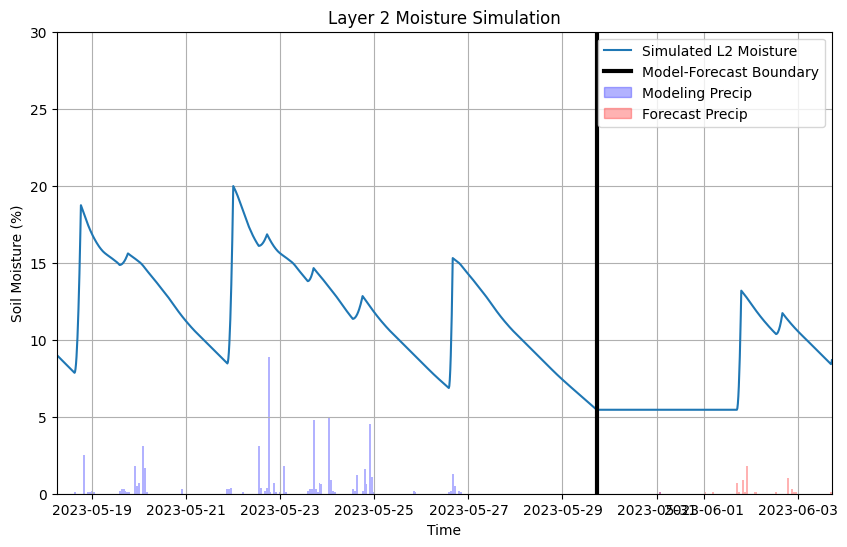

In [ ]:
start_time = pd.Timestamp("2023-05-18 06:00:00")
current = pd.Timestamp("2023-05-31 03:00:00")  # End of modeling period
start_sm = 9

# 2.1) Run the modeling simulation
sim_times, sim_vals = simulate_layer2_moisture(
    start_time=start_time,
    start_sm=start_sm,
    end_time=current,
    precip_df= Precipitation,  
    model=model_2,
    m2_x=moisture_2_x,
    m2_y=moisture_2_y,
    dt_minutes=15,
    merge_hours=6
)

df_model = pd.DataFrame({"time": sim_times, "moisture": sim_vals}).sort_values("time").reset_index(drop=True)

new_start = df_model.loc[df_model.index[-1], "time"]    # last time from modeling
new_start_sm = df_model.loc[df_model.index[-1], "moisture"]
extension_end = new_start + pd.Timedelta(days=5)

new_start_str = new_start.strftime('%Y-%m-%d')
new_end_str   = extension_end.strftime('%Y-%m-%d')
forecast_precip = get_hourly_precipitation(longitude, latitude, new_start_str, new_end_str)

forecast_times, forecast_vals = simulate_layer2_moisture(
    start_time=new_start,
    start_sm=new_start_sm,
    end_time=extension_end,
    precip_df=forecast_precip,  
    model=model_2,
    m2_x=moisture_2_x,
    m2_y=moisture_2_y,
    dt_minutes=15,
    merge_hours=6
)

df_forecast = pd.DataFrame({"time": forecast_times, "moisture": forecast_vals}).sort_values("time").reset_index(drop=True)


df_result = pd.concat([df_model, df_forecast], ignore_index=True)
df_result.drop_duplicates(subset=["time"], inplace=True)  # if overlap
df_result.sort_values("time", inplace=True, ignore_index=True)

df_result.set_index("time", inplace=True)
full_index = pd.date_range(start=df_result.index[0], end=df_result.index[-1], freq="15T")
df_result = df_result.reindex(full_index, method='ffill')  # forward-fill missing intervals
df_result.index.name = "time"
df_result.reset_index(inplace=True)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_result["time"], df_result["moisture"], label="Simulated L2 Moisture")

# Vertical line to separate modeling & forecast
plt.axvline(x=new_start, color='black', linewidth=3, linestyle='-', label='Model-Forecast Boundary')

ax.set_title("Layer 2 Moisture Simulation")
ax.set_xlabel("Time")
ax.set_ylabel("Soil Moisture (%)")
ax.grid(True)

ymin, ymax = ax.get_ylim()
precip_base = 0
rect_width = pd.Timedelta(hours=1)
for _, row in Precipitation.iterrows():
    date_val = pd.to_datetime(row['date'])
    precip_amt = row['precipitation_mm']
    if start_time <= date_val < current:
        rect = patches.Rectangle((date_val - pd.Timedelta(minutes=30), precip_base),
                                 rect_width, precip_amt,
                                 facecolor='blue', alpha=0.3, edgecolor='none')
        ax.add_patch(rect)

# Plot forecast precipitation as red rectangles
for _, row in forecast_precip.iterrows():
    date_val = pd.to_datetime(row['date'])
    precip_amt = row['precipitation_mm']
    if new_start <= date_val < extension_end:
        rect = patches.Rectangle((date_val - pd.Timedelta(minutes=30), precip_base),
                                 rect_width, precip_amt,
                                 facecolor='red', alpha=0.3, edgecolor='none')
        ax.add_patch(rect)

precip_patch = patches.Patch(color='blue', alpha=0.3, label='Modeling Precip')
forecast_patch = patches.Patch(color='red', alpha=0.3, label='Forecast Precip')
handles, labels = ax.get_legend_handles_labels()
handles.extend([precip_patch, forecast_patch])
ax.legend(handles=handles)

plt.xlim([start_time, extension_end])
plt.ylim([0, 30])
plt.show()



# Layer 3

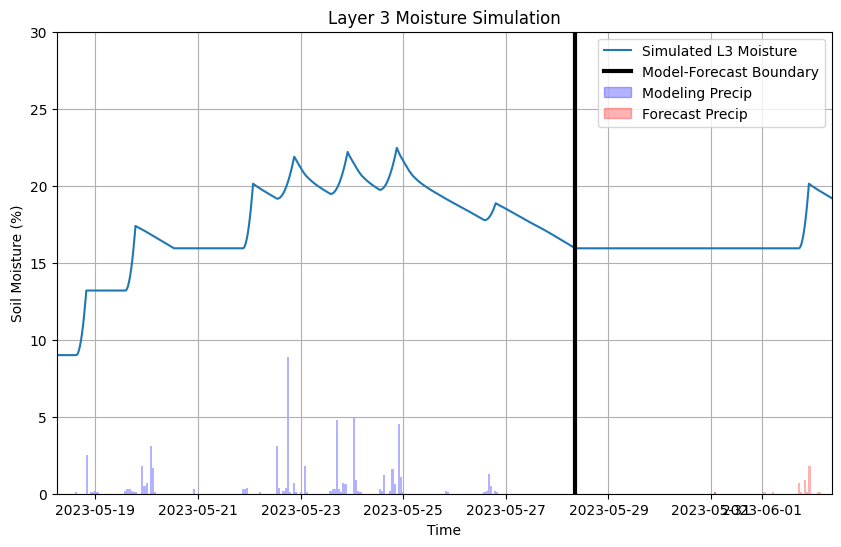

In [ ]:

def get_hourly_precipitation(lat, lon, start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,  
        "end_date": end_date,      
        "hourly": "precipitation",
        "timezone": "UTC"
    }
    response = requests.get(url, params=params)
    response.raise_for_status()
    data = response.json()
    if "hourly" in data and "time" in data["hourly"] and "precipitation" in data["hourly"]:
        times = data["hourly"]["time"]
        values = data["hourly"]["precipitation"]
        df = pd.DataFrame({
            "date": pd.to_datetime(times),
            "precipitation_mm": values
        })
        return df
    else:
        raise ValueError("No precipitation data found in response.")

def merge_precip_events(precip_df, merge_hours=3):
    df_nonzero = precip_df[precip_df['precipitation_mm'] > 0].copy()
    if df_nonzero.empty:
        return []
    df_nonzero['date'] = pd.to_datetime(df_nonzero['date'])
    df_nonzero = df_nonzero.sort_values(by='date').reset_index(drop=True)
    events = []
    current_start = df_nonzero.loc[0, 'date']
    current_end = current_start
    current_sum = df_nonzero.loc[0, 'precipitation_mm']
    for i in range(1, len(df_nonzero)):
        this_time = df_nonzero.loc[i, 'date']
        this_mm = df_nonzero.loc[i, 'precipitation_mm']
        if (this_time - current_end).total_seconds() <= merge_hours * 3600:
            current_end = this_time
            current_sum += this_mm
        else:
            if current_sum >= 1:
                events.append({'start_time': current_start, 'end_time': current_end, 'total_mm': current_sum})
            current_start = this_time
            current_end = this_time
            current_sum = this_mm
    if current_sum >= 1:
        events.append({'start_time': current_start, 'end_time': current_end, 'total_mm': current_sum})
    return events

def generate_decreasing_curve(start_time, start_sm, end_time, m3_x, m3_y, dt_minutes=15):
    if end_time <= start_time:
        return [], []
    total_minutes = (end_time - start_time).total_seconds() / 60.0
    intervals = int(np.floor(total_minutes / dt_minutes))
    diffs = np.abs(m3_y - start_sm)
    idx_found = np.argmin(diffs)
    max_idx = len(m3_y) - 1
    end_idx = idx_found + intervals
    if end_idx > max_idx:
        end_idx = max_idx
    sub_y = m3_y[idx_found:end_idx+1]
    offset = start_sm - sub_y[0]
    sub_y_offset = [val + offset for val in sub_y]
    sub_times = [start_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(sub_y_offset))]
    return sub_times, sub_y_offset

def generate_increasing_curve_xgboost(event_start_time, current_sm, water_input, event_duration_hrs, model_3, dt_minutes=15):
    X_input = np.array([[current_sm, event_duration_hrs, water_input]])
    preds = model_3.predict(X_input)
    inc_dur_pred = preds[0][0]        # hours
    sm_increase_pred = preds[0][1]    # delta in SM
    T_minutes = inc_dur_pred * 60
    initial_SM = current_sm
    peak_SM = initial_SM + sm_increase_pred
    if T_minutes <= 0:
        return [], []
    t_arr = np.arange(0, T_minutes + dt_minutes, dt_minutes)
    a = (peak_SM - initial_SM) / (T_minutes**2)
    c = initial_SM
    sm_arr = a * (t_arr**2) + c
    times = [event_start_time + pd.Timedelta(minutes=float(m)) for m in t_arr]
    return times, sm_arr

def simulate_layer3_moisture(start_time, start_sm, end_time, precip_df, model_3, m3_x, m3_y, dt_minutes=15, merge_hours=3):
    events = merge_precip_events(precip_df, merge_hours=merge_hours)
    merged_events = []
    for ev in events:
        if ev['end_time'] < start_time:
            continue
        if ev['start_time'] > end_time:
            continue
        merged_events.append(ev)
    merged_events = sorted(merged_events, key=lambda x: x['start_time'])

    full_times = []
    full_moisture = []
    current_time = start_time
    current_sm_val = start_sm

    for ev in merged_events:
        ev_start = ev['start_time']
        ev_end   = ev['end_time']
        total_mm = ev['total_mm']

        # 1) Decreasing portion
        if ev_start > current_time:
            dec_times, dec_vals = generate_decreasing_curve(
                start_time=current_time,
                start_sm=current_sm_val,
                end_time=min(ev_start, end_time),
                m3_x=m3_x,
                m3_y=m3_y,
                dt_minutes=dt_minutes
            )
            full_times.extend(dec_times)
            full_moisture.extend(dec_vals)
            if dec_times:
                current_time, current_sm_val = dec_times[-1], dec_vals[-1]

        if ev_start >= end_time:
            break

        # 2) Increasing portion
        event_duration_hrs = (ev_end - ev_start).total_seconds() / 3600.0
        inc_times, inc_vals = generate_increasing_curve_xgboost(
            event_start_time=ev_start,
            current_sm=current_sm_val,
            water_input=total_mm,
            event_duration_hrs=event_duration_hrs,
            model_3=model_3,
            dt_minutes=dt_minutes
        )
        inc_times_clipped = []
        inc_vals_clipped  = []
        for t_, v_ in zip(inc_times, inc_vals):
            if t_ <= end_time:
                inc_times_clipped.append(t_)
                inc_vals_clipped.append(v_)
            else:
                break
        full_times.extend(inc_times_clipped)
        full_moisture.extend(inc_vals_clipped)
        if inc_times_clipped:
            current_time, current_sm_val = inc_times_clipped[-1], inc_vals_clipped[-1]
        if current_time >= end_time:
            break

    # Final decreasing portion
    if current_time < end_time:
        dec_times, dec_vals = generate_decreasing_curve(
            start_time=current_time,
            start_sm=current_sm_val,
            end_time=end_time,
            m3_x=m3_x,
            m3_y=m3_y,
            dt_minutes=dt_minutes
        )
        full_times.extend(dec_times)
        full_moisture.extend(dec_vals)

    return full_times, full_moisture


start_time = pd.Timestamp("2023-05-18 06:00:00")
current 
start_sm   = 9

sim_times, sim_vals = simulate_layer3_moisture(
    start_time=start_time,
    start_sm=start_sm,
    end_time=current,
    precip_df=Precipitation,  
    model_3=model_3,         # your layer 3 model
    m3_x=moisture_3_x,
    m3_y=moisture_3_y,
    dt_minutes=15,
    merge_hours=6
)

df_model = pd.DataFrame({"time": sim_times, "moisture": sim_vals}).sort_values("time").reset_index(drop=True)

new_start = df_model.loc[df_model.index[-1], "time"]
new_start_sm = df_model.loc[df_model.index[-1], "moisture"]
extension_end = new_start + pd.Timedelta(days=5)


new_start_str = new_start.strftime('%Y-%m-%d')
new_end_str   = extension_end.strftime('%Y-%m-%d')
forecast_precip = get_hourly_precipitation(longitude, latitude, new_start_str, new_end_str)

forecast_times, forecast_vals = simulate_layer3_moisture(
    start_time=new_start,
    start_sm=new_start_sm,
    end_time=extension_end,
    precip_df=forecast_precip,
    model_3=model_3,
    m3_x=moisture_3_x,
    m3_y=moisture_3_y,
    dt_minutes=15,
    merge_hours=6
)

df_forecast = pd.DataFrame({"time": forecast_times, "moisture": forecast_vals}).sort_values("time").reset_index(drop=True)

df_layer3 = pd.concat([df_model, df_forecast], ignore_index=True)
df_layer3.drop_duplicates(subset=["time"], inplace=True)
df_layer3.sort_values("time", inplace=True, ignore_index=True)



filled_times = []
filled_vals  = []

dt_step = pd.Timedelta(minutes=15)

for i in range(len(df_layer3) - 1):
    t0 = df_layer3.loc[i, "time"]
    t1 = df_layer3.loc[i+1, "time"]
    v0 = df_layer3.loc[i, "moisture"]
    v1 = df_layer3.loc[i+1, "moisture"]


    if not filled_times or filled_times[-1] != t0:
        filled_times.append(t0)
        filled_vals.append(v0)

    total_minutes = (t1 - t0).total_seconds() / 60.0
    intervals = int(total_minutes // 15)
    if intervals > 1:

        slope = (v1 - v0) / intervals
        for step in range(1, intervals):
            new_time = t0 + step * dt_step
            new_val  = v0 + slope * step
            filled_times.append(new_time)
            filled_vals.append(new_val)


t_last = df_layer3.loc[len(df_layer3)-1, "time"]
v_last = df_layer3.loc[len(df_layer3)-1, "moisture"]
filled_times.append(t_last)
filled_vals.append(v_last)

# Rebuild a final DataFrame with continuous 15-min steps
df_layer3_filled = pd.DataFrame({"time": filled_times, "moisture": filled_vals})
df_layer3_filled.sort_values("time", inplace=True, ignore_index=True)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_layer3_filled["time"], df_layer3_filled["moisture"], label="Simulated L3 Moisture")

# Mark the boundary
plt.axvline(x=new_start, color='black', linewidth=3, linestyle='-', label='Model-Forecast Boundary')
ax.set_title("Layer 3 Moisture Simulation")
ax.set_xlabel("Time")
ax.set_ylabel("Soil Moisture (%)")
ax.grid(True)

#  modeling precipitation in blue
ymin, ymax = ax.get_ylim()
precip_base = 0
rect_width = pd.Timedelta(hours=1)
for _, row in Precipitation.iterrows():
    date_val = pd.to_datetime(row['date'])
    precip_amt = row['precipitation_mm']
    if start_time <= date_val < current:
        rect = patches.Rectangle((date_val - pd.Timedelta(minutes=30), precip_base),
                                 rect_width, precip_amt,
                                 facecolor='blue', alpha=0.3, edgecolor='none')
        ax.add_patch(rect)

#  forecast precipitation in red
for _, row in forecast_precip.iterrows():
    date_val = pd.to_datetime(row['date'])
    precip_amt = row['precipitation_mm']
    if new_start <= date_val < extension_end:
        rect = patches.Rectangle((date_val - pd.Timedelta(minutes=30), precip_base),
                                 rect_width, precip_amt,
                                 facecolor='red', alpha=0.3, edgecolor='none')
        ax.add_patch(rect)

precip_patch = patches.Patch(color='blue', alpha=0.3, label='Modeling Precip')
forecast_patch = patches.Patch(color='red', alpha=0.3, label='Forecast Precip')
handles, labels = ax.get_legend_handles_labels()
handles.extend([precip_patch, forecast_patch])
ax.legend(handles=handles)

plt.xlim([start_time, extension_end])
plt.ylim([0, 30])
plt.show()


## Combined plot three layer in one plot. 

In [100]:
def Model_1_Function(
    Segment_1, 
    filtered_rows, 
    model_1,
    moisture_1_x, 
    moisture_1_y, 
    start_dt, 
    end_dt, 
    longitude, 
    latitude,
    layer2_df=None,    
    layer3_df=None     
):


    def get_hourly_precipitation(lat, lon, start_date, end_date):
        url = "https://archive-api.open-meteo.com/v1/era5"
        params = {
            "latitude": lat,
            "longitude": lon,
            "start_date": start_date,  # "YYYY-MM-DD"
            "end_date": end_date,      # "YYYY-MM-DD"
            "hourly": "precipitation",
            "timezone": "UTC"
        }
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()

        if "hourly" in data and "time" in data["hourly"] and "precipitation" in data["hourly"]:
            times = data["hourly"]["time"]
            values = data["hourly"]["precipitation"]
            df = pd.DataFrame({
                "date": pd.to_datetime(times),
                "precipitation_mm": values
            })
            return df
        else:
            raise ValueError("No precipitation data found in response.")


    precip_input = get_hourly_precipitation(
        latitude,  
        longitude,
        start_dt, 
        end_dt + pd.Timedelta(days=5)
    )


    def build_rise_decay_curve_with_SMAP(segment_layer, precip, SMAP_DATA, model, m1_x, m1_y, 
                                         ratio, window_days=2, dt_minutes=15, prev_decreasing_end_value=None):
        # 1. Limit to data before the peak (maximum moisture_1)
        peak_idx = segment_layer['moisture_1'].idxmax()
        df_before_peak = segment_layer.loc[:peak_idx].copy()
        df_before_peak['DateTime'] = pd.to_datetime(df_before_peak['DateTime'])

        precip = precip.copy()
        precip['date'] = pd.to_datetime(precip['date'])

        df_before_peak['Water_Input'] = 0.0
        # Sum precipitation within ±window_days for each timestamp
        for i, row in df_before_peak.iterrows():
            center_time = row['DateTime']
            lower_bound = center_time - pd.Timedelta(days=window_days)
            upper_bound = center_time + pd.Timedelta(days=window_days)
            mask = (precip['date'] >= lower_bound) & (precip['date'] <= upper_bound)
            if not precip[mask].empty:
                df_before_peak.loc[i, 'Water_Input'] = precip[mask]['precipitation_mm'].sum()

        # 2. Extract features before the peak
        df_before_peak = df_before_peak.sort_values('DateTime').reset_index(drop=True)
        peak_time = df_before_peak.loc[df_before_peak['moisture_1'].idxmax(), 'DateTime']
        init_sm = df_before_peak.loc[0, 'moisture_1']
        duration_hrs = (peak_time - df_before_peak.loc[0, 'DateTime']).total_seconds() / 3600.0
        water_in = df_before_peak.loc[0, 'Water_Input']
        features = {
            'L1_InitialSM': prev_decreasing_end_value if prev_decreasing_end_value is not None else init_sm,
            'L1_IncreasingEventDuration': duration_hrs,
            'L1_WaterInput': water_in
        }

        # 3. Predict increasing curve parameters using the model.
        X_input = np.array([
            [features['L1_InitialSM'], features['L1_IncreasingEventDuration'], features['L1_WaterInput']]
        ])
        preds = model.predict(X_input)
        T_hrs, sm_increase_pr = preds[0][0], preds[0][1]
        T_minutes = T_hrs * 60
        peak_SM = features['L1_InitialSM'] + sm_increase_pr
        if T_minutes == 0:
            a, c = 0, features['L1_InitialSM']
        else:
            a = (peak_SM - features['L1_InitialSM']) / (T_minutes**2)
            c = features['L1_InitialSM']

        t_values = np.arange(0, T_minutes + dt_minutes, dt_minutes)
        sm_values = a * (t_values**2) + c
        datetime_t_values = [
            segment_layer.iloc[0]['DateTime'] + pd.Timedelta(minutes=int(x)) 
            for x in t_values
        ]

        # 4. Match the observed curve from m1_y using a time slice
        after_dur_mins = (
            segment_layer.iloc[-1]['DateTime'] - segment_layer.iloc[0]['DateTime']
        ).total_seconds() / 60.0
        target_val = sm_values[-1]
        diffs = np.abs(m1_y - target_val)
        idx_found = np.argmin(diffs)
        intervals = int(after_dur_mins / dt_minutes)
        arr_from_peak = m1_x[idx_found: idx_found + intervals + 1]
        datetime_red_time = [
            segment_layer.iloc[0]['DateTime'] + pd.Timedelta(minutes=int((val - m1_x[0]) * dt_minutes)) 
            for val in arr_from_peak
        ]
        red_vals = m1_y[arr_from_peak]

        # 5. SMAP mini-curves: include all SMAP points between start_dt and end_dt
        SMAP_DATA = SMAP_DATA.copy()
        SMAP_DATA['Datetime'] = pd.to_datetime(SMAP_DATA['Date']) + pd.Timedelta(hours=6)
        smap_points = []
        for smap_dt, smap_val in zip(
            SMAP_DATA['Datetime'],
            SMAP_DATA['SPL3SMP_E_006_Soil_Moisture_Retrieval_Data_AM_soil_moisture']
        ):
            if start_dt <= smap_dt <= end_dt:
                smap_points.append((smap_dt, smap_val))

        return datetime_t_values, sm_values, datetime_red_time, red_vals, smap_points

    def merge_multiple_curves(Segment_1, precip, SMAP_data, model, m1_x, m1_y, window_days=2, dt_minutes=15):
        all_datetime, all_y, all_smap_points = [], [], []
        prev_decreasing_end_value = None

        for key in sorted(Segment_1.keys()):
            segment = Segment_1[key]
            blue_time, blue_vals, red_time, red_vals, smap_points = build_rise_decay_curve_with_SMAP(
                segment, precip, SMAP_data, model, m1_x, m1_y, ratio=key,
                window_days=window_days, dt_minutes=dt_minutes,
                prev_decreasing_end_value=prev_decreasing_end_value
            )
            all_datetime += list(blue_time) + list(red_time)
            all_y += list(blue_vals) + list(red_vals)
            all_smap_points += smap_points

            if len(red_vals) > 0:
                prev_decreasing_end_value = red_vals[-1]

        combined = sorted(zip(all_datetime, all_y), key=lambda x: x[0])
        unique_datetime, unique_y = [], []
        for dt_val, y_val in combined:
            if unique_datetime and dt_val == unique_datetime[-1]:
                continue
            unique_datetime.append(dt_val)
            unique_y.append(y_val)

        return {
            "main_datetime": unique_datetime, 
            "main_values": unique_y, 
            "smap_points": all_smap_points
        }

    def check_precipitation_between_smap(smap_time, next_smap_time, precipitation_df):
        precipitation_df = precipitation_df.copy()
        precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])
        mask = (precipitation_df['date'] >= smap_time) & (precipitation_df['date'] < next_smap_time)
        events = precipitation_df[mask]
        event_details = []
        for _, row in events.iterrows():
            if row['precipitation_mm'] > 1:
                event_details.append({
                    'event_time': row['date'], 
                    'water_input': row['precipitation_mm']
                })
        return event_details

    def generate_increasing_curve(event_detail, model, dt_minutes=15):
        X_input = np.array([[event_detail['current_sm'], 0, event_detail['water_input']]])
        preds = model.predict(X_input)
        T_hrs, sm_increase = preds[0][0], preds[0][1]
        T_minutes = T_hrs * 60
        initial_SM = event_detail['current_sm']
        peak_SM = initial_SM + sm_increase
        if T_minutes == 0:
            a, c = 0, initial_SM
        else:
            a = (peak_SM - initial_SM) / (T_minutes**2)
            c = initial_SM

        t_values = np.arange(0, T_minutes + dt_minutes, dt_minutes)
        sm_values = a * (t_values**2) + c
        inc_times = [event_detail['event_time'] + pd.Timedelta(minutes=int(x)) for x in t_values]
        return inc_times, sm_values


    # 1. Combined model-generated curve and SMAP calibration points.
    merged = merge_multiple_curves(Segment_1, precip_input, filtered_rows, model_1, moisture_1_x, moisture_1_y)
    combined_time = merged["main_datetime"]
    combined_vals = merged["main_values"]
    all_smap_points = merged["smap_points"]

    if isinstance(combined_time[0], (int, float, np.integer, np.floating)):
        sorted_smap_points = sorted(all_smap_points, key=lambda x: x[0])
        origin = pd.to_datetime(sorted_smap_points[0][0])
        combined_time = [origin + pd.Timedelta(minutes=t) for t in combined_time]
    else:
        combined_time = pd.to_datetime(combined_time)

    sorted_smap_points = sorted(all_smap_points, key=lambda x: x[0])
    sorted_smap_points = [(pd.to_datetime(t), v) for t, v in sorted_smap_points]

    # 2. Build modified SMAP mini-curves by processing precipitation events between calibration points.
    dt_minutes = 15
    modified_mini_curves = []

    for i, (smap_time, smap_val) in enumerate(sorted_smap_points):
        if i < len(sorted_smap_points)-1:
            next_smap_time = sorted_smap_points[i+1][0]
        else:
            next_smap_time = smap_time + pd.Timedelta(hours=24)

        precip_events = check_precipitation_between_smap(smap_time, next_smap_time, precip_input)
        segments_list = []
        current_time = smap_time
        current_sm = smap_val

        for event in sorted(precip_events, key=lambda ev: ev['event_time']):
            precip_time = event['event_time']
            water_input = event['water_input']
            after_dur_mins = (precip_time - current_time).total_seconds() / 60.0
            intervals = int(after_dur_mins // dt_minutes)
            if intervals <= 0:

                inc_times, inc_vals = generate_increasing_curve({
                    'event_time': precip_time,
                    'water_input': water_input,
                    'current_sm': current_sm
                }, model_1, dt_minutes)
                segments_list.append((inc_times, inc_vals))
                if inc_times:
                    current_time, current_sm = inc_times[-1], inc_vals[-1]
                continue

            diffs = np.abs(np.array(moisture_1_y) - current_sm)
            idx_found = np.argmin(diffs)
            start_idx = idx_found
            end_idx = start_idx + intervals
            if end_idx > len(moisture_1_y)-1:
                end_idx = len(moisture_1_y)-1

            if start_idx > end_idx:

                inc_times, inc_vals = generate_increasing_curve({
                    'event_time': precip_time,
                    'water_input': water_input,
                    'current_sm': current_sm
                }, model_1, dt_minutes)
                segments_list.append((inc_times, inc_vals))
                if inc_times:
                    current_time, current_sm = inc_times[-1], inc_vals[-1]
                continue

            dec_sub_y = moisture_1_y[start_idx:end_idx+1]
            dec_sub_times = [current_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(dec_sub_y))]
            segments_list.append((dec_sub_times, dec_sub_y))
            current_time, current_sm = dec_sub_times[-1], dec_sub_y[-1]

            inc_times, inc_vals = generate_increasing_curve({
                'event_time': precip_time,
                'water_input': water_input,
                'current_sm': current_sm
            }, model_1, dt_minutes)
            segments_list.append((inc_times, inc_vals))
            if inc_times:
                current_time, current_sm = inc_times[-1], inc_vals[-1]

        # Final segment if current_time is before next SMAP point
        if current_time < next_smap_time:
            leftover_minutes = (next_smap_time - current_time).total_seconds() / 60.0
            intervals = int(leftover_minutes // dt_minutes)
            diffs = np.abs(np.array(moisture_1_y) - current_sm)
            idx_found = np.argmin(diffs)
            start_idx = idx_found
            end_idx = start_idx + intervals
            if end_idx > len(moisture_1_y)-1:
                end_idx = len(moisture_1_y)-1

            if start_idx <= end_idx:
                dec_sub_y = moisture_1_y[start_idx:end_idx+1]
                dec_sub_times = [current_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(dec_sub_y))]
                segments_list.append((dec_sub_times, dec_sub_y))
        else:
            # overshoot if happen
            if i < len(sorted_smap_points)-1:
                diff_minutes = (sorted_smap_points[i+1][0] - smap_time).total_seconds() / 60.0
            else:
                diff_minutes = 24*60
            num_steps = int(round(diff_minutes / dt_minutes))
            diffs = np.abs(np.array(moisture_1_y) - smap_val)
            idx_found = np.argmin(diffs)
            start_idx = idx_found
            end_idx = start_idx + num_steps
            sub_y = moisture_1_y[start_idx:end_idx]
            sub_times = [smap_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(sub_y))]
            segments_list.append((sub_times, sub_y))

        final_times, final_vals = [], []
        for ts, vals in segments_list:
            final_times.extend(ts)
            final_vals.extend(vals)
        modified_mini_curves.append((final_times, final_vals, smap_time))

    # 3. Build a 5-day forecast curve starting from the last mini-curve’s final point.
    final_times_mini, final_vals_mini, _ = modified_mini_curves[-1]
    new_start = final_times_mini[-1]
    new_start_sm = final_vals_mini[-1]
    new_end = new_start + pd.Timedelta(days=5)

    new_start_str = new_start.strftime('%Y-%m-%d')
    new_end_str = new_end.strftime('%Y-%m-%d')

    precip_df_daily = get_hourly_precipitation(
        latitude,  
        longitude,
        new_start_str, 
        new_end_str
    )

    precip_threshold = 1
    precip_events_new = []
    for _, row in precip_df_daily.iterrows():
        if row['precipitation_mm'] > precip_threshold:
            event_time = row['date']
            if new_start <= event_time < new_end:
                precip_events_new.append({
                    'event_time': event_time, 
                    'water_input': row['precipitation_mm']
                })
    precip_events_new = sorted(precip_events_new, key=lambda ev: ev['event_time'])

    forecast_segments = []
    current_time, current_sm = new_start, new_start_sm

    for event in precip_events_new:
        event_time = event['event_time']
        after_dur_mins = (event_time - current_time).total_seconds() / 60.0
        intervals = int(after_dur_mins / dt_minutes)

        diffs = np.abs(np.array(moisture_1_y) - current_sm)
        idx_found = np.argmin(diffs)
        start_idx = idx_found
        end_idx = start_idx + intervals
        if end_idx > len(moisture_1_y)-1:
            end_idx = len(moisture_1_y)-1

        dec_sub_y = moisture_1_y[start_idx:end_idx+1]
        dec_sub_times = [current_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(dec_sub_y))]
        forecast_segments.append((dec_sub_times, dec_sub_y))
        if dec_sub_times:
            current_time, current_sm = dec_sub_times[-1], dec_sub_y[-1]

        inc_times, inc_vals = generate_increasing_curve({
            'event_time': event_time,
            'water_input': event['water_input'],
            'current_sm': current_sm
        }, model_1, dt_minutes)
        forecast_segments.append((inc_times, inc_vals))
        if inc_times:
            current_time, current_sm = inc_times[-1], inc_vals[-1]

    if current_time < new_end:
        after_dur_mins = (new_end - current_time).total_seconds() / 60.0
        intervals = int(after_dur_mins / dt_minutes)
        diffs = np.abs(np.array(moisture_1_y) - current_sm)
        idx_found = np.argmin(diffs)
        start_idx = idx_found
        end_idx = start_idx + intervals
        dec_sub_y = moisture_1_y[start_idx:end_idx+1]
        dec_sub_times = [current_time + pd.Timedelta(minutes=j*dt_minutes) for j in range(len(dec_sub_y))]
        forecast_segments.append((dec_sub_times, dec_sub_y))

    forecast_times, forecast_vals = [], []
    for ts, vals in forecast_segments:
        forecast_times.extend(ts)
        forecast_vals.extend(vals)

    # 4. Final Plot
    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # SMAP points
    if sorted_smap_points:
        smap_times, smap_vals = zip(*sorted_smap_points)
        plt.scatter(smap_times, smap_vals, color='purple', label='SMAP Point')

    # Plot the SMAP calibrated following curve
    soil_color = 'green'
    for sub_times, sub_vals, _ in modified_mini_curves:
        plt.plot(sub_times, sub_vals, linestyle='--', color=soil_color)

    # Plot the forecast 
    plt.plot(forecast_times, forecast_vals, linestyle='-', color=soil_color, linewidth=2, 
             label='Prediction Soil Moisture')

    # current time
    if forecast_times:
        plt.plot([new_start, forecast_times[0]], [new_start_sm, forecast_vals[0]], 
                 linestyle='--', color=soil_color)

    # Vertical line 
    plt.axvline(x=new_start, color='black', linewidth=3, linestyle='-', label='Current Time')

    plt.gcf().text(0.25, 0.97, "Modelling", ha='center', va='center', fontsize=14, fontweight='bold')
    plt.gcf().text(0.75, 0.97, "Forecasting", ha='center', va='center', fontsize=14, fontweight='bold')

    # Plot precipitation 
    ymin, ymax = ax.get_ylim()
    precip_base = 0
    rect_width = pd.Timedelta(hours=1)
    for _, row in precip_input.iterrows():
        date_val = pd.to_datetime(row['date'])
        precip_amt = row['precipitation_mm']
        if date_val < end_dt:
            rect = patches.Rectangle(
                (date_val - pd.Timedelta(minutes=30), precip_base),
                rect_width, 
                precip_amt, 
                facecolor='blue', alpha=0.3, edgecolor='none'
            )
            ax.add_patch(rect)

    for _, row in precip_df_daily.iterrows():
        date_val = pd.to_datetime(row['date'])
        precip_amt = row['precipitation_mm']
        if new_start <= date_val < new_end:
            rect = patches.Rectangle(
                (date_val - pd.Timedelta(minutes=30), precip_base),
                rect_width, 
                precip_amt, 
                facecolor='red', alpha=0.3, edgecolor='none'
            )
            ax.add_patch(rect)

    # Plot layer 2 and layer 3 curves 
    if layer2_df is not None:
        layer2_df = layer2_df.copy()
        layer2_df['time'] = pd.to_datetime(layer2_df['time'])
        plt.plot(layer2_df['time'], layer2_df['moisture'], color='orange', 
                 label='Layer 2 Soil Moisture')

    if layer3_df is not None:
        layer3_df = layer3_df.copy()
        layer3_df['time'] = pd.to_datetime(layer3_df['time'])
        plt.plot(layer3_df['time'], layer3_df['moisture'], color='brown', 
                 label='Layer 3 Soil Moisture')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate(rotation=0, ha='center')
    plt.xlim([start_dt, new_end])
    plt.ylim(0, 30)
    plt.title("Modelling with SMAP Calibration & Forecasting")
    plt.xlabel("Time")
    plt.ylabel("Soil Moisture (%)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 5. Restore to CSV file
    all_times = set()
    for t, _ in sorted_smap_points:
        all_times.add(t)
    for sub_times, _, _ in modified_mini_curves:
        all_times.update(sub_times)
    all_times.update(forecast_times)
    all_times.add(new_start)

    precip_input['date'] = pd.to_datetime(precip_input['date'])
    for d in precip_input['date']:
        all_times.add(d)

    all_times = [t for t in all_times if t <= new_end]
    all_times = sorted(all_times)

    df = pd.DataFrame(index=all_times)
    df['SMAP Point (m3/m3)'] = np.nan
    for t, v in sorted_smap_points:
        if t <= new_end:
            df.loc[t, 'SMAP Point (m3/m3)'] = v

    df['Soil moisture curve (m3/m3) Surface'] = np.nan
    for sub_times, sub_vals, _ in modified_mini_curves:
        for t, v in zip(sub_times, sub_vals):
            if t <= new_end:
                df.loc[t, 'Soil moisture curve (m3/m3) Surface'] = v

    for t, v in zip(forecast_times, forecast_vals):
        if t <= new_end:
            df.loc[t, 'Soil moisture curve (m3/m3) Surface'] = v

    df.loc[new_start, 'Soil moisture curve (m3/m3) Surface'] = new_start_sm

    df['water amount(mm)'] = np.nan
    df['water type'] = np.nan
    for _, row in precip_input.iterrows():
        date_val = pd.to_datetime(row['date'])
        amt = row['precipitation_mm']
        if amt >= 0.1 and date_val <= new_end:
            df.loc[date_val, 'water amount(mm)'] = amt

            df.loc[date_val, 'water type'] = 'Precipitation'

    df['Current Time'] = new_start
    df.sort_index(inplace=True)

    df = df[~df.index.duplicated(keep='first')]


    sim_series = pd.Series(data=filled_vals, index=filled_times, name='Layer 2 moisture (m3/m3)')
    sim_series = sim_series[~sim_series.index.duplicated(keep='first')]


    new_index = df.index.union(sim_series.index)
    df = df.reindex(new_index)


    df.loc[sim_series.index, 'Layer 2 moisture (m3/m3)'] = sim_series


    df.sort_index(inplace=True)

    df = df[~df.index.duplicated(keep='first')]

    sim_series = pd.Series(data=filled_vals, index=filled_times, name='Layer 3 moisture (m3/m3)')
    sim_series = sim_series[~sim_series.index.duplicated(keep='first')]


    new_index = df.index.union(sim_series.index)
    df = df.reindex(new_index)

    df.loc[sim_series.index, 'Layer 3 moisture (m3/m3)'] = sim_series

    df.sort_index(inplace=True)

    output_csv = 'Three_layer_data.csv'
    df.to_csv(output_csv)

    return df, precip_input


In [101]:
three_layer_df, a = Model_1_Function(
    Segment_1, 
    filtered_rows, 
    model_1, 
    moisture_1_x, 
    moisture_1_y, 
    start_dt, 
    end_dt, 
    longitude, 
    latitude,
    layer2_df=df_result,       # layer 2
    layer3_df=df_layer3_filled # layer 3
)


HTTPError: 400 Client Error: Bad Request for url: https://archive-api.open-meteo.com/v1/era5?latitude=-82.3248&longitude=29.6516&start_date=2023-05-18+00%3A00%3A00&end_date=2023-06-05+00%3A00%3A00&hourly=precipitation&timezone=UTC